`Notebook: 01_data_processing.ipynb`
- Purpose:

   - load and preprocess the datasets.
   - Save preprocessed data for efficient loading.

## 1. Packages Imports

In [1]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, Normalize
import seaborn as sns
from statsmodels.tsa.stattools import grangercausalitytests, ccf
import numpy as np
import plotly.express as px
from datetime import datetime
import geopandas as gpd
import warnings
from pathlib import Path
import yaml
from tqdm import tqdm
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

# sys.path.append("../scripts")

import plotly.io as pio
pio.renderers.default = 'vscode'  # or 'notebook'

sys.path.append(os.path.abspath("../scripts"))  # Adjust the path
os.chdir(os.path.dirname(os.path.abspath("__file__")))  # Set working directory

from utils import *


## 2. Dataset Loading

In [2]:
# Define dataset directories
powercast_dir = "../datasets/raw/PowerCast_Datasets/"  

# List all files in both directories
powercast_files = os.listdir(powercast_dir)

print("Power Cast Files:", powercast_files)

Power Cast Files: ['Frequency_Containment_Reserve_202301010000_202503050000_Quarterhour.csv', 'Generation_Forecast_Intraday_202301010000_202503050000_Quarterhour.csv', 'Manual_Frequency_Restoration_Reserve_202301010000_202503050000_Quarterhour.csv', 'Forecasted_generation_Day-Ahead_202301010000_202503050000_Hour_Quarterhour.csv', 'Balancing_energy_202301010000_202503050000_Quarterhour_Month.csv', 'Costs_of_TSOs__without_costs_of_DSOs__202301010000_202503050000_Month.csv', 'Actual_consumption_202301010000_202503050000_Quarterhour.csv', 'Imported_balancing_services_202301010000_202503050000_Quarterhour.csv', 'Automatic_Frequency_Restoration_Reserve_202301010000_202503050000_Quarterhour.csv', 'Installed_generation_capacity_202301010000_202503050000_Year.csv', 'Actual_generation_202301010000_202503050000_Quarterhour.csv', 'Forecasted_consumption_202301010000_202503050000_Quarterhour.csv', 'Exported_balancing_services_202301010000_202503050000_Quarterhour.csv', 'Cross-border_physical_flows_

## 3. Preprocess Power Cast Dataset/Folder Contents

In [3]:
# List and sort all files in the directory
powercast_files = sorted(powercast_files)

# Print files with enumeration
print("\n📂 Power Cast Files:")
for idx, file in enumerate(powercast_files, start=1):
    print(f"   - {idx:02d} {file}")  # Zero-padded numbering


📂 Power Cast Files:
   - 01 Actual_consumption_202301010000_202503050000_Quarterhour.csv
   - 02 Actual_generation_202301010000_202503050000_Quarterhour.csv
   - 03 Automatic_Frequency_Restoration_Reserve_202301010000_202503050000_Quarterhour.csv
   - 04 Balancing_energy_202301010000_202503050000_Quarterhour_Month.csv
   - 05 Costs_of_TSOs__without_costs_of_DSOs__202301010000_202503050000_Month.csv
   - 06 Cross-border_physical_flows_202301010000_202503050000_Quarterhour.csv
   - 07 Day-ahead_prices_202301010000_202503050000_Hour.csv
   - 08 Exported_balancing_services_202301010000_202503050000_Quarterhour.csv
   - 09 Forecasted_consumption_202301010000_202503050000_Quarterhour.csv
   - 10 Forecasted_generation_Day-Ahead_202301010000_202503050000_Hour_Quarterhour.csv
   - 11 Frequency_Containment_Reserve_202301010000_202503050000_Quarterhour.csv
   - 12 Generation_Forecast_Intraday_202301010000_202503050000_Quarterhour.csv
   - 13 Imported_balancing_services_202301010000_202503050000_

- Total of 16 Files Supplied 

In [4]:
# Function to preview CSV files
def preview_csv(file_path, num_rows=5):
    """Load and preview a CSV file with proper formatting."""
    try:
        df = pd.read_csv(file_path, sep=";", nrows=num_rows)  # Ensure correct delimiter
        
        # Trim whitespace from column names
        df.columns = df.columns.str.strip()
        
        print(f"\n🔍 Preview of {os.path.basename(file_path)}:")
        print(df.head(10))  
        
        print("\n📊 Column Info:")
        print(df.info())  
        
        print("\n❗ Missing Values:")
        print(df.isnull().sum())  
    except Exception as e:
        print(f"⚠️ Error loading {file_path}: {e}")

# Preview power outage CSV datasets
print("\n🔎 **Power Outage Data Preview**")
for file in powercast_files:
    if file.endswith(".csv"):
        preview_csv(os.path.join(powercast_dir, file))



🔎 **Power Outage Data Preview**

🔍 Preview of Actual_consumption_202301010000_202503050000_Quarterhour.csv:
             Start date              End date  \
0  Jan 1, 2023 12:00 AM  Jan 1, 2023 12:15 AM   
1  Jan 1, 2023 12:15 AM  Jan 1, 2023 12:30 AM   
2  Jan 1, 2023 12:30 AM  Jan 1, 2023 12:45 AM   
3  Jan 1, 2023 12:45 AM   Jan 1, 2023 1:00 AM   
4   Jan 1, 2023 1:00 AM   Jan 1, 2023 1:15 AM   

  Total (grid load) [MWh] Original resolutions  \
0                                     9,673.00   
1                                     9,593.50   
2                                     9,562.00   
3                                     9,517.50   
4                                     9,433.25   

  Residual load [MWh] Original resolutions  \
0                                 1,842.50   
1                                 1,691.50   
2                                 1,442.50   
3                                 1,598.50   
4                                 1,325.50   

   Hydro pumped st

---
---
---

**Observations for First 4 Files**

**1️. Actual_consumption_202301010000_202503050000_Quarterhour.csv**
**Observations:**
- **Date columns (`Start date`, `End date`)** are stored as **objects (strings)** instead of datetime format.
- **Energy consumption columns** (e.g., `Total (grid load) [MWh]`, `Residual load [MWh]`, etc.) are stored as **objects instead of numeric types**.
- **No missing values** detected in the sample.

**Suggested Fixes:**
- Convert `Start date` and `End date` to datetime format.
- Convert energy-related columns to numeric values.

---

**2️. Actual_generation_202301010000_202503050000_Quarterhour.csv**
**Observations:**
- **Date columns (`Start date`, `End date`)** are in object (string) format.
- Some energy generation columns (`Biomass [MWh]`, `Wind onshore [MWh]`) are stored as **objects instead of numeric**.
- **No missing values** detected.

**Probable Fixes:**
- Convert `Start date` and `End date` to datetime format.
- Convert energy-related columns to numeric types.

---

**3️. Automatic_Frequency_Restoration_Reserve_202301010000_202503050000_Quarterhour.csv**
**Observations:**
- **Date columns (`Start date`, `End date`)** are stored as strings.
- **Some numerical values are in object format:** 
  - `Activation price (+) [€/MWh]` and `Activation price (-) [€/MWh]` contain `'-'`, indicating missing or invalid data.
  - `Volume procured (+) [MW]` and `Volume procured (-) [MW]` are objects instead of numeric.
- **No missing values in preview, but `'-'` may need handling.**

**Suggested Fixes:**
- Convert `Start date` and `End date` to datetime.
- Convert numeric columns to the correct types.
- Handle `'-'` values in activation prices (replace with NaN or 0).

---

**4️. Balancing_energy_202301010000_202503050000_Quarterhour_Month.csv**
**Observations:**
- **Date columns (`Start date`, `End date`)** are stored as objects.
- **Some numerical columns are objects:**
  - `Volume (+) [MWh]`, `Volume (-) [MWh]`, and `Net income [€]` contain `'-'`, indicating missing or invalid data.
- **No missing values**, but `'-'` may represent missing data.

**Suggested Fixes:**
- Convert `Start date` and `End date` to datetime.
- Convert numeric columns to proper types.
- Replace `'-'` values with `NaN` or `0`, depending on the context.

---

**Summary of Key Issues Across All Files**
**Date columns should be converted to datetime format.**  
**Energy-related columns should be converted to numeric types.**  
**Some files contain `'-'` in numeric fields, which should be handled.**  

---
---
---

**Observations for the next 4** 

**5. Costs_of_TSOs__without_costs_of_DSOs__202301010000_202503050000_Month.csv**  
- **Time range:** January 2023 – March 2025  
- **Resolution:** Monthly  
- **Columns:**  
  - `Start date` and `End date` (Monthly intervals)  
  - `Balancing services [€]`  
  - `Network security of the TSOs [€]`  
  - `Countertrading [€]`  
- **Issues:**  
  - All cost values are stored as strings, requiring conversion to numeric.  
  - Column names contain extra text `"Original resolutions"`, which may need cleaning.  

**6. Cross-border_physical_flows_202301010000_202503050000_Quarterhour.csv**  
- **Time range:** January 2023 – March 2025  
- **Resolution:** 15-minute intervals  
- **Columns:**  
  - `Start date` and `End date` (Quarter-hourly timestamps)  
  - `Net export [MWh]`  
  - Country-specific imports and exports (`Netherlands`, `Switzerland`, `Denmark`, `France`, etc.)  
- **Issues:**  
  - Some import values are negative, which could indicate a reversal in flow direction.  
  - The `Net export [MWh]` column is stored as a string instead of numeric.  
  - Column names are lengthy due to `"Original resolutions"` text.  

**7. Day-ahead_prices_202301010000_202503050000_Hour.csv**  
- **Time range:** January 2023 – March 2025  
- **Resolution:** Hourly  
- **Columns:**  
  - `Start date` and `End date` (Hourly timestamps)  
  - Day-ahead electricity prices for various countries (`Germany/Luxembourg`, `Belgium`, `France`, `Austria`, `Poland`, etc.)  
- **Issues:**  
  - Some price values are negative, indicating negative electricity prices during surplus conditions.  
  - `DE/AT/LU [€/MWh]` contains `"-"` instead of numeric values, requiring handling.  
  - `"Original resolutions"` text in column names.  

---

**8. Exported_balancing_services_202301010000_202503050000_Quarterhour.csv**  
- **Time range:** January 2023 – March 2025  
- **Resolution:** 15-minute intervals  
- **Columns:**  
  - `Start date`, `End date` (Quarter-hourly timestamps)  
  - `Austria [MWh]` (Exported balancing services)  

- **Issues:**  
  - `"Original resolutions"` text needs removal from column names.  
  - The `Start date` and `End date` are in string format and need conversion to `datetime`.  
  - No missing values detected.  

---


**General Observations & Next Steps**  
1. **Data Cleaning Needed:**  
   - Convert numeric columns from strings.  
   - Remove `"Original resolutions"` text from column names.  
   - Handle missing or incorrect values (`"-"`, negative prices).  
2. **Data Type Adjustments:**  
   - Convert timestamps to `datetime`.  
   - Ensure cost and energy values are in appropriate numeric formats.  
3. **Potential Analysis:**  
   - Compare trends in balancing costs and cross-border electricity flows.  
   - Identify periods with negative electricity prices.  
   - Correlate cross-border flows with price fluctuations.  


---
---
---

**Observations from the Next 4 Files**  

**9. Forecasted_consumption_202301010000_202503050000_Quarterhour.csv**  
- **Time range:** January 2023 – March 2025  
- **Resolution:** 15-minute intervals  
- **Columns:**  
  - `Start date`, `End date` (Quarter-hourly timestamps)  
  - `Total (grid load) [MWh]` (Total electricity consumption forecast)  
  - `Residual load [MWh]` (Forecasted load after subtracting renewable generation)  

- **Issues:**  
  - Numeric values (`Total (grid load) [MWh]`, `Residual load [MWh]`) are stored as strings and require conversion.  
  - `"Original resolutions"` text in column names.  
  - The `Start date` and `End date` need conversion to `datetime`.  
  - No missing values detected.  

---

**10. Forecasted_generation_Day-Ahead_202301010000_202503050000_Hour_Quarterhour.csv**  
- **Time range:** January 2023 – March 2025  
- **Resolution:** 15-minute intervals  
- **Columns:**  
  - `Start date`, `End date` (Quarter-hourly timestamps)  
  - `Total [MWh]` (Total forecasted generation)  
  - `Photovoltaics and wind [MWh]`, `Wind offshore [MWh]`, `Wind onshore [MWh]`, `Photovoltaics [MWh]`, `Other [MWh]`  

- **Issues:**  
  - `"Original resolutions"` text in column names.  
  - Some values in `Total [MWh]` and `Other [MWh]` contain `"-"`, indicating missing data. These should be handled appropriately.  
  - The `Start date` and `End date` need conversion to `datetime`.  

---

**11. Frequency_Containment_Reserve_202301010000_202503050000_Quarterhour.csv**  
- **Time range:** January 2023 – March 2025  
- **Resolution:** 15-minute intervals  
- **Columns:**  
  - `Start date`, `End date` (Quarter-hourly timestamps)  
  - `Volume procured [MW]` (Total power procured for frequency containment reserve)  
  - `Procurement price [€/MW]` (Price per MW for procurement)  

- **Issues:**  
  - `"Original resolutions"` text in column names.  
  - `Volume procured [MW]` contains only `"-"`, indicating missing or unavailable data.  
  - The `Start date` and `End date` need conversion to `datetime`.  
  - The `Procurement price [€/MW]` is correctly stored as a numeric type.  

---

 **12. `Generation_Forecast_Intraday_202301010000_202503050000_Quarterhour.csv`**
   - Contains quarter-hourly renewable energy generation forecasts.
   - Columns include **total renewable generation (MWh), wind offshore, wind onshore, and photovoltaics**.
   - **Data types:** Some numerical columns are stored as `object`, requiring conversion to `float`.
   - **Missing values:** None detected.

---

**General Observations & Next Steps**  
**Common Issues Across All Files:**  
1. **Column Cleaning:** Remove `"Original resolutions"` from column names.  
2. **Datetime Conversion:** Convert `Start date` and `End date` to `datetime` format.  
3. **Numeric Conversion:** Convert string-based numeric columns to `float`.  
4. **Handling Missing Values:**  
   - `"-"` values in **Forecasted Generation** and **Frequency Containment Reserve** datasets require proper imputation or removal.  
   - `Volume procured [MW]` contains no actual values, requiring investigation.  

---
---
---

**Observations for the Last 4 Files:**

**13. `Imported_balancing_services_202301010000_202503050000_Quarterhour.csv`**
   - Contains quarter-hourly imported balancing services.
   - Only one country (`Austria [MWh]`) is listed.
   - **Data types:** All numeric columns are correctly stored as `float64`.
   - **Missing values:** None detected.

**14. `Installed_generation_capacity_202301010000_202503050000_Year.csv`**
   - Contains yearly installed generation capacity for multiple energy sources.
   - Columns include **biomass, hydropower, wind (offshore & onshore), photovoltaics, nuclear, lignite, hard coal, fossil gas, and other sources**.
   - **Data types:** Many numeric columns are stored as `object`, requiring conversion to `float`.
   - **Missing values:** None detected.

**15. `Manual_Frequency_Restoration_Reserve_202301010000_202503050000_Quarterhour.csv`**
   - Contains quarter-hourly data on **manual frequency restoration reserves**.
   - **Activation volumes and prices** (`+` and `-` directions) appear as `"-"`, suggesting missing or unavailable data.
   - **Procurement volumes and prices** are available and stored as `float64`.
   - **Data types:** Some columns require conversion due to `"-"` placeholders.
   - **Missing values:** Columns with `"-"` should be checked and handled appropriately.

**16. `Scheduled_commercial_exchanges_202301010000_202503050000_Quarterhour.csv`**
   - Contains quarter-hourly **cross-border electricity trade data**.
   - Columns include **net exports, exports, and imports for multiple countries** (Netherlands, Switzerland, Denmark, Czech Republic, Austria, etc.).
   - **Data types:** Some numeric values (e.g., negative imports) are stored as `object`, requiring conversion to `float`.
   - **Missing values:** None detected.

---
**Next Steps:**
1. Convert numerical columns from `object` to `float` where needed.
2. Handle missing or placeholder values (e.g., `"-"` in manual frequency restoration reserve).
3. Verify data consistency, especially in cross-border trade balances.

In [5]:
def optimize_dataframe_memory(df):
    df = df.copy()
    print(f"Original memory usage: {df.memory_usage().sum() / 1024 ** 2:.2f} MB")
    
    # Downcasting integers
    int_cols = df.select_dtypes(include=['int64', 'int32']).columns
    df[int_cols] = df[int_cols].apply(pd.to_numeric, downcast='integer')
    
    # Downcasting floats
    float_cols = df.select_dtypes(include=['float64']).columns
    df[float_cols] = df[float_cols].apply(pd.to_numeric, downcast='float')
    
    # Converting object columns to category if there are fewer unique values than 50% of total rows
    object_cols = df.select_dtypes(include=['object']).columns
    for col in object_cols:
        num_unique_values = df[col].nunique()
        num_total_values = len(df[col])
        if num_unique_values / num_total_values < 0.5:
            df[col] = df[col].astype('category')
    
    print(f"Optimized memory usage: {df.memory_usage().sum() / 1024 ** 2:.2f} MB")
    return df

def display_dataframe_info(df):
    # Print the shape of the dataframe
    print('Shape:', df.shape)
    
    # Print the column names with their data types
    dtypes_list = [f"{col}:{dtype}" for col, dtype in zip(df.columns, df.dtypes)]
    print('Dtypes:', dtypes_list)
    
    # Print the column names with the percentage of missing values
    missings_list = [f"{col}:{missing:.2f}%" for col, missing in zip(df.columns, df.isnull().mean()*100)]
    print('Missings (%):', missings_list)
    
    # Calculate total missing percentage
    total_missing_percentage = (df.isnull().sum().sum() / df.size) * 100
    print(f'Total missings (%): {total_missing_percentage:.2f}%')

    
    # Print total duplicates
    print('total duplicates:', df.duplicated(keep=False).sum())
    
    # Print the total memory consumed by the dataframe
    memory_usage = df.memory_usage().sum() / 1024**2  # Convert bytes to megabytes (MB)
    print(f"Total memory usage: {memory_usage:.2f} MB")
    
    # Display the first 2 rows of the dataframe
    return df.head(2)

def detect_mixed_and_abnormal_types(df, threshold=0.01):
    """
    Detects mixed data types and abnormal values in a DataFrame.

    Parameters:
    - df (pd.DataFrame): The DataFrame to analyze.
    - threshold (float): Proportion of rows with abnormal types or values for flagging a column (default: 0.01).

    Returns:
    - pd.DataFrame: A summary of detected issues in the dataset.
    """
    results = []

    for col in df.columns:
        # Identify mixed types
        mixed_types = df[col].apply(lambda x: type(x)).nunique() > 1

        # Check for abnormal types (non-numeric in numeric columns, etc.)
        if pd.api.types.is_numeric_dtype(df[col]):
            abnormal_types = df[col].apply(lambda x: not isinstance(x, (int, float)) and not pd.isna(x)).sum()
        elif pd.api.types.is_string_dtype(df[col]) or pd.api.types.is_categorical_dtype(df[col]):
            abnormal_types = df[col].astype(str).apply(lambda x: not isinstance(x, str)).sum()
        else:
            abnormal_types = 0

        abnormal_types_percent = abnormal_types / len(df)

        # Detect abnormal values (extreme outliers)
        if pd.api.types.is_numeric_dtype(df[col]):
            q1 = df[col].quantile(0.25)
            q3 = df[col].quantile(0.75)
            iqr = q3 - q1
            lower_bound = q1 - 1.5 * iqr
            upper_bound = q3 + 1.5 * iqr
            abnormal_values = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
            abnormal_values_percent = abnormal_values / len(df)
        else:
            abnormal_values = 0
            abnormal_values_percent = 0

        # Append results
        results.append({
            "Column": col,
            "Mixed Types": mixed_types,
            "Abnormal Types Count": abnormal_types,
            "Abnormal Types (%)": abnormal_types_percent * 100,
            "Abnormal Values Count": abnormal_values,
            "Abnormal Values (%)": abnormal_values_percent * 100,
        })

    # Create a summary DataFrame
    results_df = pd.DataFrame(results)
    flagged_columns = results_df[
        (results_df["Mixed Types"]) |
        (results_df["Abnormal Types (%)"] > threshold * 100) |
        (results_df["Abnormal Values (%)"] > threshold * 100)
    ]
    
    return results_df, flagged_columns

In [6]:
print(powercast_files)
# outages_dir

['Actual_consumption_202301010000_202503050000_Quarterhour.csv', 'Actual_generation_202301010000_202503050000_Quarterhour.csv', 'Automatic_Frequency_Restoration_Reserve_202301010000_202503050000_Quarterhour.csv', 'Balancing_energy_202301010000_202503050000_Quarterhour_Month.csv', 'Costs_of_TSOs__without_costs_of_DSOs__202301010000_202503050000_Month.csv', 'Cross-border_physical_flows_202301010000_202503050000_Quarterhour.csv', 'Day-ahead_prices_202301010000_202503050000_Hour.csv', 'Exported_balancing_services_202301010000_202503050000_Quarterhour.csv', 'Forecasted_consumption_202301010000_202503050000_Quarterhour.csv', 'Forecasted_generation_Day-Ahead_202301010000_202503050000_Hour_Quarterhour.csv', 'Frequency_Containment_Reserve_202301010000_202503050000_Quarterhour.csv', 'Generation_Forecast_Intraday_202301010000_202503050000_Quarterhour.csv', 'Imported_balancing_services_202301010000_202503050000_Quarterhour.csv', 'Installed_generation_capacity_202301010000_202503050000_Year.csv', '

In [7]:
print(powercast_dir)

../datasets/raw/PowerCast_Datasets/


In [8]:

# # # Dictionary to store cleaned DataFrames
# cleaned_df = {}

# # Function to clean a DataFrame
# def clean_dataframe(df, filename):
#     # Convert date columns (assume first column is datetime)
#     datetime_col = df.columns[0]
#     df[datetime_col] = pd.to_datetime(df[datetime_col], errors='coerce')

#     # Convert numeric columns (except datetime column)
#     for col in df.columns[1:]:
#         df[col] = pd.to_numeric(df[col], errors='coerce')

#     # Replace invalid values ("-") with NaN
#     df.replace("-", np.nan, inplace=True)

#     # Standardize column names (remove extra text)
#     df.columns = [col.replace("Original resolutions", "").strip() for col in df.columns]

#     # Detect negative values (especially in price & cross-border flow datasets)
#     negative_values = df[df.select_dtypes(include=['number']) < 0].dropna(how="all")
#     if not negative_values.empty:
#         print(f"⚠️ Warning: Negative values detected in {filename}")

#     return df

# # Load and clean each dataset
# for file in powercast_files:
#     filepath = os.path.join(powercast_dir, file)
#     try:
#         df = pd.read_csv(filepath, delimiter=";")
#         cleaned_df = clean_dataframe(df, file)
#         cleaned_df[file] = cleaned_df
#         print(f"✅ {file} loaded and cleaned successfully.")
#     except Exception as e:
#         print(f"❌ Error processing {file}: {e}")

# # All cleaned DataFrames are stored in `cleaned_dfs`
# cleaned_df

In [9]:
# Define file path
file_path = powercast_dir + "Day-ahead_prices_202301010000_202503050000_Hour.csv"

# Load the dataset
df_raw = pd.read_csv(file_path, delimiter=';')

# Check if the column exists
print("de/at/lu column exists:", "DE/AT/LU [€/MWh] Original resolutions" in df_raw.columns)

print("unique values: ", df_raw['DE/AT/LU [€/MWh] Original resolutions'].unique())
# Show the first few rows (specifically for de/at/lu)
df_raw[['Start date', 'End date', 'DE/AT/LU [€/MWh] Original resolutions']].head()

de/at/lu column exists: True
unique values:  ['-']


,Start date,End date,DE/AT/LU [€/MWh] Original resolutions
0,"Jan 1, 2023 12:00 AM","Jan 1, 2023 1:00 AM",-
1,"Jan 1, 2023 1:00 AM","Jan 1, 2023 2:00 AM",-
2,"Jan 1, 2023 2:00 AM","Jan 1, 2023 3:00 AM",-
3,"Jan 1, 2023 3:00 AM","Jan 1, 2023 4:00 AM",-
4,"Jan 1, 2023 4:00 AM","Jan 1, 2023 5:00 AM",-


### 3.1 Actual_consumption_202301010000_202503050000_Quarterhour.csv

In [10]:
# actual_consumption_df = pd.read_csv(powercast_dir/f"{powercast_files[0]}", sep=";")
print("actual_consumption_quarterhour_file:", powercast_files[0])
print("=="*80)
actual_consumption_quarterhour_df = pd.read_csv(os.path.join(powercast_dir, powercast_files[0]), sep=";")
print("=="*80)
print("actual_consumption_quarterhour_df info:", "\n", actual_consumption_quarterhour_df.info())
print("=="*80)
print("actual_consumption_quarterhour_df missingness:", "\n", actual_consumption_quarterhour_df.isnull().mean() * 100)
print("actual_consumption_quarterhour_df sample head:")
actual_consumption_quarterhour_df.head(3)

actual_consumption_quarterhour_file: Actual_consumption_202301010000_202503050000_Quarterhour.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76224 entries, 0 to 76223
Data columns (total 5 columns):
 #   Column                                           Non-Null Count  Dtype 
---  ------                                           --------------  ----- 
 0   Start date                                       76224 non-null  object
 1   End date                                         76224 non-null  object
 2   Total (grid load) [MWh] Original resolutions     76224 non-null  object
 3   Residual load [MWh] Original resolutions         76224 non-null  object
 4   Hydro pumped storage [MWh] Original resolutions  76224 non-null  object
dtypes: object(5)
memory usage: 2.9+ MB
actual_consumption_quarterhour_df info: 
 None
actual_consumption_quarterhour_df missingness: 
 Start date                                         0.0
End date                                           0.0
Total (gr

,Start date,End date,Total (grid load) [MWh] Original resolutions,Residual load [MWh] Original resolutions,Hydro pumped storage [MWh] Original resolutions
0,"Jan 1, 2023 12:00 AM","Jan 1, 2023 12:15 AM","9,673.00","1,842.50",494.00
1,"Jan 1, 2023 12:15 AM","Jan 1, 2023 12:30 AM","9,593.50","1,691.50",502.50
2,"Jan 1, 2023 12:30 AM","Jan 1, 2023 12:45 AM","9,562.00","1,442.50",561.00


- All are confirmed objects and would be converted to appropriate types

"**Original resolutions**" likely indicates that the data is provided in its **raw temporal resolution**—in this case, quarter-hourly intervals. This suggests that:  

1. **No Aggregation or Downsampling**: The dataset reflects the original measured or forecasted values without any transformation (e.g., hourly, daily, or monthly averaging).  
2. **Consistency with Other Datasets**: Other datasets may have different resolutions (hourly, daily, monthly), so this label clarifies that these values haven't been resampled.  
3. **Metadata Tag**: It serves as additional metadata, possibly redundant when working with the data programmatically.  

In [11]:
df = actual_consumption_quarterhour_df.copy()

# Mask for missing values only (exact match with '-')
mask_missing = df.applymap(lambda x: str(x).strip() == "-")

# Mask for negative numeric values
mask_negative = df.applymap(lambda x: str(x).strip().startswith("-") and str(x).strip() != "-")

# Extract rows with missing values and negative values separately
rows_with_missing = df[mask_missing.any(axis=1)]
rows_with_negative = df[mask_negative.any(axis=1)]

# Print counts and percentages
total_rows = df.shape[0]
missing_count = len(rows_with_missing)
negative_count = len(rows_with_negative)

print(f"Total Rows in Dataset: {total_rows}")
print(f"Rows with '-': {missing_count} ({(missing_count / total_rows) * 100:.2f}%)")
print(f"Rows with negative values: {negative_count} ({(negative_count / total_rows) * 100:.2f}%)")



Total Rows in Dataset: 76224
Rows with '-': 17 (0.02%)
Rows with negative values: 537 (0.70%)


In [12]:
# Show samples
print("\nAll rows with '-':")
rows_with_missing


All rows with '-':


,Start date,End date,Total (grid load) [MWh] Original resolutions,Residual load [MWh] Original resolutions,Hydro pumped storage [MWh] Original resolutions
76207,"Mar 4, 2025 7:45 PM","Mar 4, 2025 8:00 PM",-,-,-
76208,"Mar 4, 2025 8:00 PM","Mar 4, 2025 8:15 PM",-,-,-
76209,"Mar 4, 2025 8:15 PM","Mar 4, 2025 8:30 PM",-,-,-
76210,"Mar 4, 2025 8:30 PM","Mar 4, 2025 8:45 PM",-,-,-
76211,"Mar 4, 2025 8:45 PM","Mar 4, 2025 9:00 PM",-,-,-
76212,"Mar 4, 2025 9:00 PM","Mar 4, 2025 9:15 PM",-,-,-
76213,"Mar 4, 2025 9:15 PM","Mar 4, 2025 9:30 PM",-,-,-
76214,"Mar 4, 2025 9:30 PM","Mar 4, 2025 9:45 PM",-,-,-
76215,"Mar 4, 2025 9:45 PM","Mar 4, 2025 10:00 PM",-,-,-
76216,"Mar 4, 2025 10:00 PM","Mar 4, 2025 10:15 PM",-,-,-



---

1. **Rows with `'-'` (Missing Data): 17 rows (0.02%)**  
   - These occur at the **very end of the dataset** (March 4, 2025, from 7:45 PM to 12:00 AM).
   - Possible causes:
     - Data might not have been available yet when the dataset was compiled.
     - The source system may have encountered an issue in logging these values.
   - **Actionable Steps:**  
     - If other datasets also have missing values at the end, it might indicate an issue with the data collection process.
     - Options for handling:
       - **Drop these rows** (since they are minimal and at the very end).
       - **Impute using previous values** (if time continuity is important).

2. **Rows with Negative Values: 537 rows (0.70%)**  
   - This suggests negative values are more common and should be investigated.
   - **Key observation:**  
     - These appear in the **Residual Load** column (e.g., `-164.50` MWh, `-933.75` MWh).
     - Negative **Residual Load** can happen when renewables (wind/solar) generate more than the grid load, causing excess power.
   - **Actionable Steps:**  
     - **Confirm if negatives are expected for residual load.**  
     - **Check other datasets for similar behavior** (cross-border flows, balancing energy).  
     - If negatives are valid, we **leave them as is** and document them. Otherwise, we consider absolute values if appropriate.



---
 

**Step 1: Understanding Residual Load**  

**Residual Load = Total Grid Load - Renewable Generation**  
- If renewables (wind, solar, etc.) exceed demand, residual load can be negative.  
- This typically happens during high wind/solar production and low consumption periods (e.g., midday in spring/summer).  

**Step 2: Investigate the Negative Values**

**1️. Check which columns have negatives**
This will confirm if negatives are **only in Residual Load** or in other columns like **Grid Load** or **Hydro Pumped Storage**.

**2️. Check when and how negatives occur**

This will show the **dates/times** when negative residual load occurs. If it aligns with high renewable energy production, it’s likely valid.

**3️. Cross-check with renewable generation data**
- If we have **wind/solar generation** datasets, we can check if **high renewables** correlate with **negative residual load**.

**4️. Compare with other sources**
- **SMARD / Bundesnetzagentur** data should mention whether negative residual load is expected.
- Checking similar datasets (e.g., cross-border flows) might help.

---

In [13]:
negative_counts = actual_consumption_quarterhour_df.apply(lambda x: (x.astype(str).str.startswith("-")).sum())
print("Negative Value Counts per Column:\n", negative_counts)


Negative Value Counts per Column:
 Start date                                           0
End date                                             0
Total (grid load) [MWh] Original resolutions        17
Residual load [MWh] Original resolutions           554
Hydro pumped storage [MWh] Original resolutions     17
dtype: int64


In [14]:
rows_with_negative = actual_consumption_quarterhour_df[
    actual_consumption_quarterhour_df.apply(lambda x: x.astype(str).str.startswith("-")).any(axis=1)
]
rows_with_negative[['Start date', 'End date', 'Residual load [MWh] Original resolutions']].head(10)


,Start date,End date,Residual load [MWh] Original resolutions
9541,"Apr 10, 2023 10:15 AM","Apr 10, 2023 10:30 AM",-164.50
9542,"Apr 10, 2023 10:30 AM","Apr 10, 2023 10:45 AM",-426.75
9543,"Apr 10, 2023 10:45 AM","Apr 10, 2023 11:00 AM",-662.50
9544,"Apr 10, 2023 11:00 AM","Apr 10, 2023 11:15 AM",-933.75
9545,"Apr 10, 2023 11:15 AM","Apr 10, 2023 11:30 AM","-1,152.25"
9546,"Apr 10, 2023 11:30 AM","Apr 10, 2023 11:45 AM","-1,250.50"
9547,"Apr 10, 2023 11:45 AM","Apr 10, 2023 12:00 PM","-1,382.50"
9548,"Apr 10, 2023 12:00 PM","Apr 10, 2023 12:15 PM","-1,349.75"
9549,"Apr 10, 2023 12:15 PM","Apr 10, 2023 12:30 PM","-1,450.25"
9550,"Apr 10, 2023 12:30 PM","Apr 10, 2023 12:45 PM","-1,436.25"


In [15]:
def clean_column_names(df):
    rename_dict = {
        "Start date": "start_date",
        "End date": "end_date",
        "Total (grid load) [MWh] Original resolutions": "total_grid_load_mwh",
        "Residual load [MWh] Original resolutions": "residual_load_mwh",
        "Hydro pumped storage [MWh] Original resolutions": "hydro_pumped_storage_mwh"
    }
    df = df.rename(columns=rename_dict)
    return df

df = clean_column_names(df)

print(df.columns)


Index(['start_date', 'end_date', 'total_grid_load_mwh', 'residual_load_mwh',
       'hydro_pumped_storage_mwh'],
      dtype='object')


In [16]:
df.replace("-", np.nan, inplace=True)
numeric_cols = ['total_grid_load_mwh', 'residual_load_mwh','hydro_pumped_storage_mwh']
df[numeric_cols] = df[numeric_cols].replace(",", "", regex=True).astype(float)

df[numeric_cols]

,total_grid_load_mwh,residual_load_mwh,hydro_pumped_storage_mwh
0,9673.00,1842.5,494.00
1,9593.50,1691.5,502.50
2,9562.00,1442.5,561.00
3,9517.50,1598.5,519.25
4,9433.25,1325.5,301.00
...,...,...,...
76219,NaN,NaN,NaN
76220,NaN,NaN,NaN
76221,NaN,NaN,NaN
76222,NaN,NaN,NaN


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76224 entries, 0 to 76223
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   start_date                76224 non-null  object 
 1   end_date                  76224 non-null  object 
 2   total_grid_load_mwh       76207 non-null  float64
 3   residual_load_mwh         76207 non-null  float64
 4   hydro_pumped_storage_mwh  76207 non-null  float64
dtypes: float64(3), object(2)
memory usage: 2.9+ MB


In [18]:

df['start_date'] = pd.to_datetime(df['start_date'], format="%b %d, %Y %I:%M %p")
df['end_date'] = pd.to_datetime(df['end_date'], format="%b %d, %Y %I:%M %p")

df.replace("-", np.nan, inplace=True)
numeric_cols = ['total_grid_load_mwh', 'residual_load_mwh','hydro_pumped_storage_mwh']
df[numeric_cols] = df[numeric_cols].replace(",", "", regex=True).astype(float)

# Compute implied renewable generation
df["implied_renewable_generation"] = df["total_grid_load_mwh"] - df["residual_load_mwh"]

# Show affected rows
df_neg_residuals = df[df["residual_load_mwh"] < 0]
df_neg_residuals[["start_date", "total_grid_load_mwh", 
                   "residual_load_mwh", "implied_renewable_generation"]]


,start_date,total_grid_load_mwh,residual_load_mwh,implied_renewable_generation
9541,2023-04-10 10:15:00,10598.00,-164.50,10762.50
9542,2023-04-10 10:30:00,10743.00,-426.75,11169.75
9543,2023-04-10 10:45:00,10778.00,-662.50,11440.50
9544,2023-04-10 11:00:00,10820.25,-933.75,11754.00
9545,2023-04-10 11:15:00,10936.75,-1152.25,12089.00
...,...,...,...,...
62556,2024-10-13 16:00:00,11737.75,-76.50,11814.25
70228,2025-01-01 13:00:00,13176.50,-9.50,13186.00
70229,2025-01-01 13:15:00,12992.50,-84.75,13077.25
70230,2025-01-01 13:30:00,12940.25,-74.50,13014.75


In [19]:
df_neg_residuals[["start_date", "total_grid_load_mwh", 
                   "residual_load_mwh", "implied_renewable_generation"]].describe()

,start_date,total_grid_load_mwh,residual_load_mwh,implied_renewable_generation
count,537,537.000000,537.000000,537.000000
mean,2024-02-28 05:28:21.117318656,11489.114060,-563.168994,12052.283054
min,2023-04-10 10:15:00,9134.250000,-2183.750000,9379.250000
25%,2023-10-03 11:30:00,10545.750000,-858.750000,11000.750000
50%,2024-04-27 13:15:00,11217.250000,-402.000000,11754.000000
75%,2024-07-28 15:15:00,12079.750000,-177.500000,12872.500000
max,2025-01-01 13:45:00,15541.000000,-1.000000,16789.500000
std,NaN,1391.089347,490.453234,1523.806549


In [20]:
# Check if Implied Renewables > Total Grid Load for negative residual load cases
df_neg_residuals.loc[:,"valid_negative_residual"] = df_neg_residuals["implied_renewable_generation"] > df_neg_residuals["total_grid_load_mwh"]

# Count how many cases meet the expected condition
valid_cases = df_neg_residuals["valid_negative_residual"].sum()
invalid_cases = len(df_neg_residuals) - valid_cases

# Print results
print(f"Valid cases where Implied Renewables > Total Grid Load: {valid_cases} ({(valid_cases / len(df_neg_residuals)) * 100:.2f}%)")
print(f"Invalid cases where this condition does NOT hold: {invalid_cases} ({(invalid_cases / len(df_neg_residuals)) * 100:.2f}%)")

# Show the rows where the condition is NOT met
df_neg_residuals[~df_neg_residuals["valid_negative_residual"]]


Valid cases where Implied Renewables > Total Grid Load: 537 (100.00%)
Invalid cases where this condition does NOT hold: 0 (0.00%)


/var/folders/l6/vts3rj213910_pfyglhvktx00000gn/T/ipykernel_8724/3982011572.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,start_date,end_date,total_grid_load_mwh,residual_load_mwh,hydro_pumped_storage_mwh,implied_renewable_generation,valid_negative_residual



---
**Validation Passed!**  

Since **100% of the negative residual load cases satisfy**:  
\[
\text{Implied Renewables} > \text{Total Grid Load}
\]
this confirms that the negative values are expected and **not errors**.  

---

**Interpretation:**
1. **Negative residual load occurs when total renewable generation exceeds total demand.**  
   - This means the sum of **wind, solar, hydro (excluding pumped storage), and other renewables** was greater than the total electricity consumption during those times.
   
2. **Since we don’t have explicit wind & solar data, Implied Renewables fills that gap.**  
   - If we had actual wind/solar data, we could further confirm that these events align with high renewable output.

3. **No correction is needed** for these negative values, as they are a real physical phenomenon rather than an error in the dataset.  

---

- `Now we apply the entire logic to the main dataframe, since we see it work on the copy`

In [21]:
  # 1️ Rename columns
rename_dict = {
        "Start date": "start_date",
        "End date": "end_date",
        "Total (grid load) [MWh] Original resolutions": "total_grid_load_mwh",
        "Residual load [MWh] Original resolutions": "residual_load_mwh",
        "Hydro pumped storage [MWh] Original resolutions": "hydro_pumped_storage_mwh"
    }

def clean_dataframe(df, dict):
    """Cleans and standardizes the power system dataset."""
    

    df = df.rename(columns=dict)

    # 2️ Handle missing values ("-" → NaN)
    df.replace("-", np.nan, inplace=True)

    # 3️ Convert numeric columns (remove commas and convert to float)
    numeric_cols = ['total_grid_load_mwh', 'residual_load_mwh', 'hydro_pumped_storage_mwh']
    df[numeric_cols] = df[numeric_cols].replace(",", "", regex=True).astype(float)

    # 4️ Convert date columns (explicit format to avoid warnings)
    df['start_date'] = pd.to_datetime(df['start_date'], format="%b %d, %Y %I:%M %p")
    df['end_date'] = pd.to_datetime(df['end_date'], format="%b %d, %Y %I:%M %p")

    return df

actual_consumption_quarterhour_df = clean_dataframe(actual_consumption_quarterhour_df, rename_dict)

actual_consumption_quarterhour_df

,start_date,end_date,total_grid_load_mwh,residual_load_mwh,hydro_pumped_storage_mwh
0,2023-01-01 00:00:00,2023-01-01 00:15:00,9673.00,1842.5,494.00
1,2023-01-01 00:15:00,2023-01-01 00:30:00,9593.50,1691.5,502.50
2,2023-01-01 00:30:00,2023-01-01 00:45:00,9562.00,1442.5,561.00
3,2023-01-01 00:45:00,2023-01-01 01:00:00,9517.50,1598.5,519.25
4,2023-01-01 01:00:00,2023-01-01 01:15:00,9433.25,1325.5,301.00
...,...,...,...,...,...
76219,2025-03-04 22:45:00,2025-03-04 23:00:00,NaN,NaN,NaN
76220,2025-03-04 23:00:00,2025-03-04 23:15:00,NaN,NaN,NaN
76221,2025-03-04 23:15:00,2025-03-04 23:30:00,NaN,NaN,NaN
76222,2025-03-04 23:30:00,2025-03-04 23:45:00,NaN,NaN,NaN


In [22]:
rows_with_negative = actual_consumption_quarterhour_df[
    actual_consumption_quarterhour_df.apply(lambda x: x.astype(str).str.startswith("-")).any(axis=1)
]
rows_with_negative.head(10)


,start_date,end_date,total_grid_load_mwh,residual_load_mwh,hydro_pumped_storage_mwh
9541,2023-04-10 10:15:00,2023-04-10 10:30:00,10598.00,-164.50,892.00
9542,2023-04-10 10:30:00,2023-04-10 10:45:00,10743.00,-426.75,1131.00
9543,2023-04-10 10:45:00,2023-04-10 11:00:00,10778.00,-662.50,1529.75
9544,2023-04-10 11:00:00,2023-04-10 11:15:00,10820.25,-933.75,1456.25
9545,2023-04-10 11:15:00,2023-04-10 11:30:00,10936.75,-1152.25,1507.50
9546,2023-04-10 11:30:00,2023-04-10 11:45:00,11058.25,-1250.50,1611.75
9547,2023-04-10 11:45:00,2023-04-10 12:00:00,11056.75,-1382.50,1708.75
9548,2023-04-10 12:00:00,2023-04-10 12:15:00,11105.75,-1349.75,1719.50
9549,2023-04-10 12:15:00,2023-04-10 12:30:00,11044.00,-1450.25,1760.75
9550,2023-04-10 12:30:00,2023-04-10 12:45:00,11024.75,-1436.25,1800.00


---
---
---
### 3.2 The Remaining 15 Datasets Processed At Once

`Let's move on to the remaining datasets, but this time we'll just assess the dataframe and run 'cleaning function' on it at once.
`


In [23]:
# powercast_files[4]
# powercast_files[13]
#  Costs_of_TSOs__without_costs_of_DSOs__202301010000_202503050000_Month.csv
#  Installed_generation_capacity_202301010000_202503050000_Year.csv:
# pd.read_csv(os.path.join(powercast_dir, powercast_files[1]), sep=";", low_memory=False)

In [24]:

# Dictionary to store cleaned DataFrames
cleaned_dfs = {}

def clean_dataframe(df):
    """Cleans and standardizes an unknown power system dataset."""
    
    df.columns = df.columns.str.lower().str.strip()
    
    # Remove parentheses but retain the text inside them
    df.columns = df.columns.str.replace(r"[()]", "", regex=True)
   
    
    # Retain units while replacing brackets with an underscore
    df.columns = df.columns.str.replace(r"\s*\[([^\]]+)\]", r"_\1", regex=True)
    
    # Remove "Original Resolutions" text
    df.columns = df.columns.str.replace(r"\s*original resolutions", "", regex=True)
    
    # Replace spaces with underscores
    df.columns = df.columns.str.replace(r"\s+", "_", regex=True)

    

    #2. Handle missing values
    df.replace("-", np.nan, inplace=True)

    #3. Convert potential date columns with explicit format guessing
    for col in df.columns:
        if "date" in col.lower():
            # df[col] = pd.to_datetime(df[col], format="%b %d, %Y %I:%M %p")
            df[col] = pd.to_datetime(df[col], format="mixed")

    #4. Identify and convert numeric columns (handling mixed types)
    for col in df.select_dtypes(include=["object"]).columns:
        # if df[col].str.replace(",", "", regex=True).str.isnumeric().all():
        df[col] = df[col].replace(",", "", regex=True).astype(float)
            


    return df


#  Load and clean each dataset
for file in powercast_files:
    filepath = os.path.join(powercast_dir, file)
    try:
        # Load CSV with `low_memory=False` to handle mixed types
        df = pd.read_csv(filepath, delimiter=";", low_memory=False, dtype=str)

        # Clean the dataframe
        cleaned_df = clean_dataframe(df)

        # Store cleaned dataframe in dictionary
        cleaned_dfs[file] = cleaned_df

        print(f"✅ {file} loaded and cleaned successfully.")
    
    except Exception as e:
        print(f"❌ Error processing {file}: {e}")

cleaned_dfs['Actual_consumption_202301010000_202503050000_Quarterhour.csv'].head(1)

✅ Actual_consumption_202301010000_202503050000_Quarterhour.csv loaded and cleaned successfully.
✅ Actual_generation_202301010000_202503050000_Quarterhour.csv loaded and cleaned successfully.
✅ Automatic_Frequency_Restoration_Reserve_202301010000_202503050000_Quarterhour.csv loaded and cleaned successfully.
✅ Balancing_energy_202301010000_202503050000_Quarterhour_Month.csv loaded and cleaned successfully.
✅ Costs_of_TSOs__without_costs_of_DSOs__202301010000_202503050000_Month.csv loaded and cleaned successfully.
✅ Cross-border_physical_flows_202301010000_202503050000_Quarterhour.csv loaded and cleaned successfully.
✅ Day-ahead_prices_202301010000_202503050000_Hour.csv loaded and cleaned successfully.
✅ Exported_balancing_services_202301010000_202503050000_Quarterhour.csv loaded and cleaned successfully.
✅ Forecasted_consumption_202301010000_202503050000_Quarterhour.csv loaded and cleaned successfully.
✅ Forecasted_generation_Day-Ahead_202301010000_202503050000_Hour_Quarterhour.csv loade

,start_date,end_date,total_grid_load_mwh,residual_load_mwh,hydro_pumped_storage_mwh
0,2023-01-01,2023-01-01 00:15:00,9673.0,1842.5,494.0


- `creating insightful variables for each dataset`

In [25]:

# Load datasets into variables
# Insights: 2 monthly res, 1 hourly res, 12 quarterhourly, 1 yearly res
# 12/16 of the supplied datasets have original resolutions (quarterhourly or 15mins interval)

actual_consum_quarterhourly_df = cleaned_dfs['Actual_consumption_202301010000_202503050000_Quarterhour.csv'] #1
actual_gen_quarterhourly_df = cleaned_dfs['Actual_generation_202301010000_202503050000_Quarterhour.csv'] #2
auto_freq_restore_quarterhourly_df = cleaned_dfs['Automatic_Frequency_Restoration_Reserve_202301010000_202503050000_Quarterhour.csv'] #3
balancing_energy_monthly_df = cleaned_dfs['Balancing_energy_202301010000_202503050000_Quarterhour_Month.csv'] #4
tso_costs_monthly_df = cleaned_dfs['Costs_of_TSOs__without_costs_of_DSOs__202301010000_202503050000_Month.csv'] #5
cross_border_quarterhourly_df = cleaned_dfs['Cross-border_physical_flows_202301010000_202503050000_Quarterhour.csv'] #6
day_ahead_price_hourly_df = cleaned_dfs['Day-ahead_prices_202301010000_202503050000_Hour.csv'] #7
exported_balancing_quarterhourly_df = cleaned_dfs['Exported_balancing_services_202301010000_202503050000_Quarterhour.csv'] #8
forecasted_consum_quarterhourly_df = cleaned_dfs['Forecasted_consumption_202301010000_202503050000_Quarterhour.csv'] #9
forecasted_gen_quarterhourly_df = cleaned_dfs['Forecasted_generation_Day-Ahead_202301010000_202503050000_Hour_Quarterhour.csv'] #10
freq_containm_quarterhourly_df = cleaned_dfs['Frequency_Containment_Reserve_202301010000_202503050000_Quarterhour.csv'] #11
gen_forecast_quarterhourly_df = cleaned_dfs['Generation_Forecast_Intraday_202301010000_202503050000_Quarterhour.csv'] #12
imported_balancing_quarterhourly_df = cleaned_dfs['Imported_balancing_services_202301010000_202503050000_Quarterhour.csv'] #13
installed_gen_yearly_df = cleaned_dfs['Installed_generation_capacity_202301010000_202503050000_Year.csv'] #14
manual_freq_quarterhourly_df = cleaned_dfs['Manual_Frequency_Restoration_Reserve_202301010000_202503050000_Quarterhour.csv'] #15
scheduled_exchanges_quarterhourly_df = cleaned_dfs['Scheduled_commercial_exchanges_202301010000_202503050000_Quarterhour.csv'] #16


In [26]:
balancing_energy_monthly_df.columns

Index(['start_date', 'end_date', 'volume_+_mwh', 'volume_-_mwh', 'price_€/mwh',
       'net_income_€'],
      dtype='object')

### 3.3 Deeper Processing of Each Dataset Using SMARD User Guide

- The SMARD User Guide (https://www.smard.de/resource/blob/205652/63fcff2c9813096fa2229d769da164ef/smard-user-guide-09-2021-data.pdf) provides useful information to further organise the datasets and gain critical understanding for analysis.

- We will search each dataset groupings (1 - 16) to get more info


#### 3.3.1 Deeper Organisation of `actual_consum_quarterhourly_df`

In [27]:
actual_consum_quarterhourly_df.columns

Index(['start_date', 'end_date', 'total_grid_load_mwh', 'residual_load_mwh',
       'hydro_pumped_storage_mwh'],
      dtype='object')

In [28]:
actual_consum_quarterhourly_df.head(2)

,start_date,end_date,total_grid_load_mwh,residual_load_mwh,hydro_pumped_storage_mwh
0,2023-01-01 00:00:00,2023-01-01 00:15:00,9673.0,1842.5,494.0
1,2023-01-01 00:15:00,2023-01-01 00:30:00,9593.5,1691.5,502.5


In [66]:
actual_consum_quarterhourly_df.isnull().mean() * 100

start_date                  0.000000
end_date                    0.000000
total_grid_load_mwh         0.022303
residual_load_mwh           0.022303
hydro_pumped_storage_mwh    0.022303
dtype: float64

- Restructure for consistency

In [29]:
df_actual_consum_quarterhourly_copy = actual_consum_quarterhourly_df.melt(
    id_vars=["start_date", "end_date"], 
    var_name="consumption_type", 
    value_name="consumption_mwh"
)

# Remove "_mwh" suffix for consistency
df_actual_consum_quarterhourly_copy["consumption_type"] = df_actual_consum_quarterhourly_copy["consumption_type"].str.replace("_mwh", "", regex=False)

df_actual_consum_quarterhourly_copy.head()


,start_date,end_date,consumption_type,consumption_mwh
0,2023-01-01 00:00:00,2023-01-01 00:15:00,total_grid_load,9673.00
1,2023-01-01 00:15:00,2023-01-01 00:30:00,total_grid_load,9593.50
2,2023-01-01 00:30:00,2023-01-01 00:45:00,total_grid_load,9562.00
3,2023-01-01 00:45:00,2023-01-01 01:00:00,total_grid_load,9517.50
4,2023-01-01 01:00:00,2023-01-01 01:15:00,total_grid_load,9433.25


In [30]:
df_actual_consum_quarterhourly_copy.describe().T

,count,mean,min,25%,50%,75%,max,std
start_date,228672,2024-02-02 00:24:46.020151040,2023-01-01 00:00:00,2023-07-18 12:56:15,2024-02-01 23:52:30,2024-08-18 12:48:45,2025-03-04 23:45:00,NaN
end_date,228672,2024-02-02 00:39:43.753148416,2023-01-01 00:15:00,2023-07-18 13:11:15,2024-02-02 00:07:30,2024-08-18 13:03:45,2025-03-05 00:00:00,NaN
consumption_mwh,228621.0,7089.564773,-2183.75,592.0,7641.25,12067.5,19145.5,5808.014131


- dataset already well-structured
- Checking time gaps and missingness

In [31]:
expected_timestamps = pd.date_range(
    start=df_actual_consum_quarterhourly_copy['start_date'].min(),
      end=df_actual_consum_quarterhourly_copy['end_date'].max(),
    freq='15T'
)
missing_timestamps = expected_timestamps.difference(df_actual_consum_quarterhourly_copy['start_date'])
print(missing_timestamps)


DatetimeIndex(['2023-03-26 02:00:00', '2023-03-26 02:15:00',
               '2023-03-26 02:30:00', '2023-03-26 02:45:00',
               '2024-03-31 02:00:00', '2024-03-31 02:15:00',
               '2024-03-31 02:30:00', '2024-03-31 02:45:00',
               '2025-03-05 00:00:00'],
              dtype='datetime64[ns]', freq=None)


- possible Daylight Saving issues

The missing timestamps on March 26 and March 31 at 02:00–02:45 are due to Daylight Saving Time (DST) transitions when the clock jumps forward by one hour in Europe. These gaps are expected and should not be artificially interpolated, as no actual data exists for those times.

In [32]:
df_actual_consum_quarterhourly_copy[df_actual_consum_quarterhourly_copy['start_date'].between("2025-03-05 00:00:00", "2025-03-05 01:00:00")]


,start_date,end_date,consumption_type,consumption_mwh


- Since the DST-related gaps are expected and do not require interpolation, we can move on

In [33]:
df_actual_consum_quarterhourly_copy.isnull().mean() * 100

start_date          0.000000
end_date            0.000000
consumption_type    0.000000
consumption_mwh     0.022303
dtype: float64

- very few and negigible rows

In [34]:
missing_rows = df_actual_consum_quarterhourly_copy[df_actual_consum_quarterhourly_copy.isnull().any(axis=1)]
missing_rows


,start_date,end_date,consumption_type,consumption_mwh
76207,2025-03-04 19:45:00,2025-03-04 20:00:00,total_grid_load,NaN
76208,2025-03-04 20:00:00,2025-03-04 20:15:00,total_grid_load,NaN
76209,2025-03-04 20:15:00,2025-03-04 20:30:00,total_grid_load,NaN
76210,2025-03-04 20:30:00,2025-03-04 20:45:00,total_grid_load,NaN
76211,2025-03-04 20:45:00,2025-03-04 21:00:00,total_grid_load,NaN
76212,2025-03-04 21:00:00,2025-03-04 21:15:00,total_grid_load,NaN
76213,2025-03-04 21:15:00,2025-03-04 21:30:00,total_grid_load,NaN
76214,2025-03-04 21:30:00,2025-03-04 21:45:00,total_grid_load,NaN
76215,2025-03-04 21:45:00,2025-03-04 22:00:00,total_grid_load,NaN
76216,2025-03-04 22:00:00,2025-03-04 22:15:00,total_grid_load,NaN


#### 3.3.2 Deeper Organisation of `actual_gen_quarterhourly_df`

In [35]:
actual_gen_quarterhourly_df.columns

Index(['start_date', 'end_date', 'biomass_mwh', 'hydropower_mwh',
       'wind_offshore_mwh', 'wind_onshore_mwh', 'photovoltaics_mwh',
       'other_renewable_mwh', 'nuclear_mwh', 'lignite_mwh', 'hard_coal_mwh',
       'fossil_gas_mwh', 'hydro_pumped_storage_mwh', 'other_conventional_mwh'],
      dtype='object')

In [67]:
actual_gen_quarterhourly_df.isnull().mean() * 100

start_date                   0.000000
end_date                     0.000000
biomass_mwh                  0.022303
hydropower_mwh               0.022303
wind_offshore_mwh            0.020991
wind_onshore_mwh             0.022303
photovoltaics_mwh            0.022303
other_renewable_mwh          0.022303
nuclear_mwh                 50.312238
lignite_mwh                  0.022303
hard_coal_mwh                0.022303
fossil_gas_mwh               0.022303
hydro_pumped_storage_mwh     0.022303
other_conventional_mwh       0.022303
dtype: float64

In [36]:
actual_gen_quarterhourly_df.head(2)

,start_date,end_date,biomass_mwh,hydropower_mwh,wind_offshore_mwh,wind_onshore_mwh,photovoltaics_mwh,other_renewable_mwh,nuclear_mwh,lignite_mwh,hard_coal_mwh,fossil_gas_mwh,hydro_pumped_storage_mwh,other_conventional_mwh
0,2023-01-01 00:00:00,2023-01-01 00:15:00,1006.25,319.75,684.25,7145.75,0.50,32.25,615.25,962.75,517.0,453.75,31.75,307.25
1,2023-01-01 00:15:00,2023-01-01 00:30:00,1003.50,317.25,743.50,7158.25,0.25,32.25,614.75,963.25,518.0,453.50,45.00,307.25


In [37]:
actual_gen_quarterhourly_df.describe().T

,count,mean,min,25%,50%,75%,max,std
start_date,76224,2024-02-02 00:24:46.020151552,2023-01-01 00:00:00,2023-07-18 12:56:15,2024-02-01 23:52:30,2024-08-18 12:48:45,2025-03-04 23:45:00,NaN
end_date,76224,2024-02-02 00:39:43.753148928,2023-01-01 00:15:00,2023-07-18 13:11:15,2024-02-02 00:07:30,2024-08-18 13:03:45,2025-03-05 00:00:00,NaN
biomass_mwh,76207.0,1049.060077,819.0,994.25,1052.5,1102.0,1255.25,78.463385
hydropower_mwh,76207.0,450.639439,220.75,365.75,450.5,521.25,817.0,103.056894
wind_offshore_mwh,76208.0,712.710191,0.0,284.0,665.5,1103.25,1992.0,473.078636
wind_onshore_mwh,76207.0,3298.582725,10.25,1229.5,2585.0,4827.0,12039.5,2573.122306
photovoltaics_mwh,76207.0,1633.118792,0.0,0.5,14.75,2517.5,11753.0,2564.23145
other_renewable_mwh,76207.0,29.519483,17.25,24.25,27.25,33.5,51.25,7.190331
nuclear_mwh,37874.0,177.978013,0.0,0.0,0.0,528.0,771.0,298.454887
lignite_mwh,76207.0,2148.805192,615.5,1386.5,2146.75,2812.0,4300.25,869.4746


In [38]:
actual_gen_quarterhourly_df.isnull().mean() * 100

start_date                   0.000000
end_date                     0.000000
biomass_mwh                  0.022303
hydropower_mwh               0.022303
wind_offshore_mwh            0.020991
wind_onshore_mwh             0.022303
photovoltaics_mwh            0.022303
other_renewable_mwh          0.022303
nuclear_mwh                 50.312238
lignite_mwh                  0.022303
hard_coal_mwh                0.022303
fossil_gas_mwh               0.022303
hydro_pumped_storage_mwh     0.022303
other_conventional_mwh       0.022303
dtype: float64

In [39]:
missing_nuclear = actual_gen_quarterhourly_df[actual_gen_quarterhourly_df['nuclear_mwh'].isnull()][['start_date', 'end_date']]
print(missing_nuclear.head(10))  # Show first 10 rows
print(missing_nuclear['start_date'].min(), "to", missing_nuclear['start_date'].max())  # Check date range


               start_date            end_date
37874 2024-01-30 12:30:00 2024-01-30 12:45:00
37875 2024-01-30 12:45:00 2024-01-30 13:00:00
37876 2024-01-30 13:00:00 2024-01-30 13:15:00
37877 2024-01-30 13:15:00 2024-01-30 13:30:00
37878 2024-01-30 13:30:00 2024-01-30 13:45:00
37879 2024-01-30 13:45:00 2024-01-30 14:00:00
37880 2024-01-30 14:00:00 2024-01-30 14:15:00
37881 2024-01-30 14:15:00 2024-01-30 14:30:00
37882 2024-01-30 14:30:00 2024-01-30 14:45:00
37883 2024-01-30 14:45:00 2024-01-30 15:00:00
2024-01-30 12:30:00 to 2025-03-04 23:45:00


The missing nuclear generation values start from **2024-01-30 12:30:00** and continue up to **2025-03-04 23:45:00**. This suggests that either:  

1. **Reporting stopped** for nuclear generation after this timestamp.  
2. **A data source issue** led to missing values beyond this point.  
3. **A phase-out or shutdown** of nuclear generation occurred in the data region.  


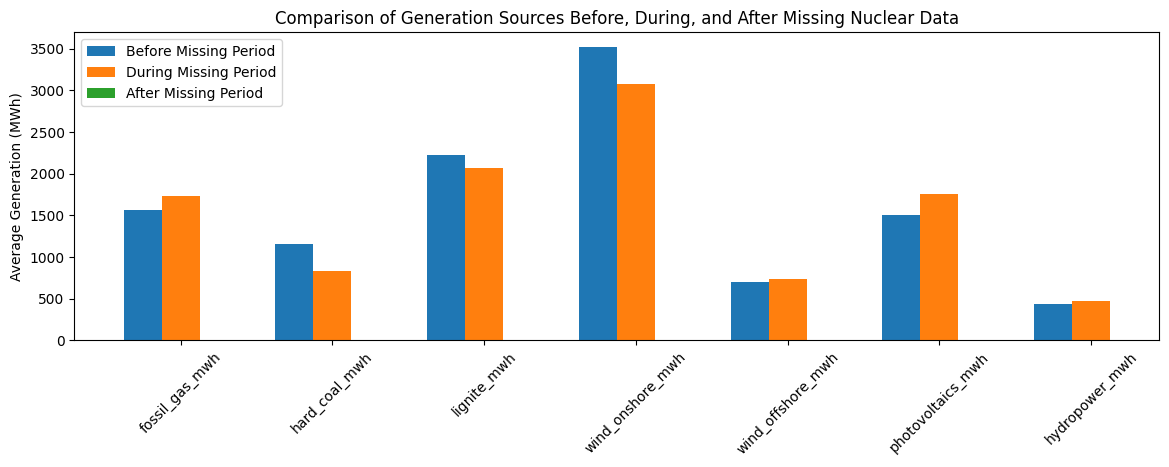

In [40]:
# Define the time range where nuclear generation is missing
start_missing = "2024-01-30 12:30:00"
end_missing = "2025-03-04 23:45:00"

# Filter data before, during, and after the missing period
before_missing = actual_gen_quarterhourly_df[actual_gen_quarterhourly_df["start_date"] < start_missing]
during_missing = actual_gen_quarterhourly_df[
    (actual_gen_quarterhourly_df["start_date"] >= start_missing) & 
    (actual_gen_quarterhourly_df["start_date"] <= end_missing)
]
after_missing = actual_gen_quarterhourly_df[actual_gen_quarterhourly_df["start_date"] > end_missing]

# Select key generation sources
gen_sources = ["fossil_gas_mwh", "hard_coal_mwh", "lignite_mwh", "wind_onshore_mwh", 
               "wind_offshore_mwh", "photovoltaics_mwh", "hydropower_mwh"]

# Aggregate generation by period
before_avg = before_missing[gen_sources].mean()
during_avg = during_missing[gen_sources].mean()
after_avg = after_missing[gen_sources].mean()

# Plot comparison
fig, ax = plt.subplots(figsize=(14, 4))
index = range(len(gen_sources))

ax.bar(index, before_avg, width=0.25, label="Before Missing Period", align="center")
ax.bar([i + 0.25 for i in index], during_avg, width=0.25, label="During Missing Period", align="center")
ax.bar([i + 0.5 for i in index], after_avg, width=0.25, label="After Missing Period", align="center")

ax.set_xticks([i + 0.25 for i in index])
ax.set_xticklabels(gen_sources, rotation=45)
ax.set_ylabel("Average Generation (MWh)")
ax.set_title("Comparison of Generation Sources Before, During, and After Missing Nuclear Data")
ax.legend()
plt.show()


The `after_avg` values being `NaN` indicate that there are no recorded values for any generation sources after the missing period. This suggests that the dataset might be truncated or entirely missing records beyond **2025-03-04 23:45:00**.


1. **During the nuclear missing period**, some generation sources increased:
   - **Fossil gas increased** (from **1564.5 MWh** → **1732.3 MWh**).
   - **Photovoltaics increased** (from **1507.8 MWh** → **1756.97 MWh**).
   - **Hydropower slightly increased** (from **431.8 MWh** → **469.2 MWh**).
   - **Wind offshore increased** (from **696.49 MWh** → **728.73 MWh**).
   
2. **Hard coal and lignite decreased**:
   - **Hard coal dropped** from **1151.0 MWh** → **829.5 MWh**.
   - **Lignite slightly dropped** from **2226.6 MWh** → **2071.9 MWh**.
   
3. **The dataset might be incomplete after 2025-03-04**, leading to `NaN` values in `after_avg`.  


In [41]:
actual_gen_quarterhourly_df[['start_date','end_date']].describe()

,start_date,end_date
count,76224,76224
mean,2024-02-02 00:24:46.020151552,2024-02-02 00:39:43.753148928
min,2023-01-01 00:00:00,2023-01-01 00:15:00
25%,2023-07-18 12:56:15,2023-07-18 13:11:15
50%,2024-02-01 23:52:30,2024-02-02 00:07:30
75%,2024-08-18 12:48:45,2024-08-18 13:03:45
max,2025-03-04 23:45:00,2025-03-05 00:00:00


- The dataset ends on 2025-03-04 at 23:45:00, which explains why all values in after_avg are NaN. There are simply no records beyond this point.

- restructuring...

In [42]:
df_actual_gen_quarterhourly_copy = actual_gen_quarterhourly_df.melt(
    id_vars=["start_date", "end_date"], 
    var_name="energy_source", 
    value_name="actual_generation_mwh"
)

# Remove "_mwh" suffix for consistency
df_actual_gen_quarterhourly_copy["energy_source"] = df_actual_gen_quarterhourly_copy["energy_source"].str.replace("_mwh", "", regex=False)

df_actual_gen_quarterhourly_copy.head()


,start_date,end_date,energy_source,actual_generation_mwh
0,2023-01-01 00:00:00,2023-01-01 00:15:00,biomass,1006.25
1,2023-01-01 00:15:00,2023-01-01 00:30:00,biomass,1003.50
2,2023-01-01 00:30:00,2023-01-01 00:45:00,biomass,1003.00
3,2023-01-01 00:45:00,2023-01-01 01:00:00,biomass,1001.50
4,2023-01-01 01:00:00,2023-01-01 01:15:00,biomass,997.50


#### 3.3.3 Deeper Organisation of `auto_freq_restore_quarterhourly_df`

In [43]:
auto_freq_restore_quarterhourly_df.head(2)

,start_date,end_date,volume_activated_+_mwh,volume_activated_-_mwh,activation_price_+_€/mwh,activation_price_-_€/mwh,volume_procured_+_mw,volume_procured_-_mw,procurement_price_+_€/mw,procurement_price_-_€/mw
0,2023-01-01 00:00:00,2023-01-01 00:15:00,0.00,15.50,NaN,NaN,1941.0,2029.0,0.52,7.52
1,2023-01-01 00:15:00,2023-01-01 00:30:00,20.75,41.75,NaN,NaN,1941.0,2029.0,0.52,7.52


In [68]:
auto_freq_restore_quarterhourly_df.isnull().mean() * 100

start_time                      0.000000
end_time                        0.000000
activated_energy_up_mwh        60.626574
activated_energy_down_mwh      60.626574
activated_price_up_€/mwh      100.000000
activated_price_down_€/mwh    100.000000
procured_reserve_up_mw         77.209278
procured_reserve_down_mw       77.209278
procured_price_up_€/mwh        77.209278
procured_price_down_€/mwh      77.209278
dtype: float64

In [44]:
auto_freq_restore_quarterhourly_df.columns

Index(['start_date', 'end_date', 'volume_activated_+_mwh',
       'volume_activated_-_mwh', 'activation_price_+_€/mwh',
       'activation_price_-_€/mwh', 'volume_procured_+_mw',
       'volume_procured_-_mw', 'procurement_price_+_€/mw',
       'procurement_price_-_€/mw'],
      dtype='object')

The dataset `auto_freq_restore_quarterhourly_df` aligns with the automatic frequency restoration reserve (aFRR) data (SMARD Website), reported at a **quarter-hourly** resolution. It includes:  

- **Activated balancing energy**: `volume_activated_+_mwh`, `volume_activated_-_mwh` (MWh)  
- **Prices for activated energy**: `activation_price_+_€/mwh`, `activation_price_-_€/mwh` (€/MWh)  
- **Procured balancing reserves**: `volume_procured_+_mw`, `volume_procured_-_mw` (MW)  
- **Prices for procured reserves**: `procurement_price_+_€/mw`, `procurement_price_-_€/mw` (€/MW)  

This dataset covers multiple **regions**, including the **Germany/Luxembourg bidding zone, Germany, Austria, and the APG control area**.  

Key considerations:  
- Prices for negative balancing services have specific algebraic sign conventions.  
- Germany and Austria/APG follow different reference periods for procured balancing service prices.  

- renaming

In [45]:
# Define renaming dictionary
rename_dict = {
    "start_date": "start_time",
    "end_date": "end_time",
    "volume_activated_+_mwh": "activated_energy_up_mwh",
    "volume_activated_-_mwh": "activated_energy_down_mwh",
    "activation_price_+_€/mwh": "activated_price_up_€/mwh",
    "activation_price_-_€/mwh": "activated_price_down_€/mwh",
    "volume_procured_+_mw": "procured_reserve_up_mw",
    "volume_procured_-_mw": "procured_reserve_down_mw",
    "procurement_price_+_€/mw": "procured_price_up_€/mwh",
    "procurement_price_-_€/mw": "procured_price_down_€/mwh"
}

# Rename columns
auto_freq_restore_quarterhourly_df.rename(columns=rename_dict, inplace=True)

# Display the first few rows after renaming
auto_freq_restore_quarterhourly_df.head()


,start_time,end_time,activated_energy_up_mwh,activated_energy_down_mwh,activated_price_up_€/mwh,activated_price_down_€/mwh,procured_reserve_up_mw,procured_reserve_down_mw,procured_price_up_€/mwh,procured_price_down_€/mwh
0,2023-01-01 00:00:00,2023-01-01 00:15:00,0.00,15.50,NaN,NaN,1941.0,2029.0,0.52,7.52
1,2023-01-01 00:15:00,2023-01-01 00:30:00,20.75,41.75,NaN,NaN,1941.0,2029.0,0.52,7.52
2,2023-01-01 00:30:00,2023-01-01 00:45:00,0.00,82.50,NaN,NaN,1941.0,2029.0,0.52,7.52
3,2023-01-01 00:45:00,2023-01-01 01:00:00,19.00,11.25,NaN,NaN,1941.0,2029.0,0.52,7.52
4,2023-01-01 01:00:00,2023-01-01 01:15:00,155.00,0.00,NaN,NaN,1941.0,2029.0,0.52,7.52


In [46]:
auto_freq_restore_quarterhourly_df.describe().T

,count,mean,min,25%,50%,75%,max,std
start_time,76224,2024-02-02 00:24:46.020151552,2023-01-01 00:00:00,2023-07-18 12:56:15,2024-02-01 23:52:30,2024-08-18 12:48:45,2025-03-04 23:45:00,NaN
end_time,76224,2024-02-02 00:39:43.753148928,2023-01-01 00:15:00,2023-07-18 13:11:15,2024-02-02 00:07:30,2024-08-18 13:03:45,2025-03-05 00:00:00,NaN
activated_energy_up_mwh,30012.0,19.98703,0.0,0.0,1.75,21.0,494.5,40.16515
activated_energy_down_mwh,30012.0,25.026889,0.0,0.0,5.0,30.8125,436.25,42.987172
activated_price_up_€/mwh,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
activated_price_down_€/mwh,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
procured_reserve_up_mw,17372.0,2108.527458,1533.0,1957.0,2083.0,2226.0,4794.0,192.019869
procured_reserve_down_mw,17372.0,2159.707,1550.0,1995.0,2142.0,2306.0,3041.0,221.869501
procured_price_up_€/mwh,17372.0,2.72426,0.3,0.94,1.7,2.59,31.17,3.732673
procured_price_down_€/mwh,17372.0,3.353205,0.19,0.73,1.47,3.71,52.49,5.395003


`Missing Activation Prices: Requires investigation.`

In [47]:
missing_values = auto_freq_restore_quarterhourly_df.isnull().sum()
missing_percentage = (missing_values / len(auto_freq_restore_quarterhourly_df)) * 100
missing_summary = pd.DataFrame({'Missing Values': missing_values, 'Missing Percentage': missing_percentage})

missing_summary[missing_summary['Missing Values'] > 0]


,Missing Values,Missing Percentage
activated_energy_up_mwh,46212,60.626574
activated_energy_down_mwh,46212,60.626574
activated_price_up_€/mwh,76224,100.000000
activated_price_down_€/mwh,76224,100.000000
procured_reserve_up_mw,58852,77.209278
procured_reserve_down_mw,58852,77.209278
procured_price_up_€/mwh,58852,77.209278
procured_price_down_€/mwh,58852,77.209278


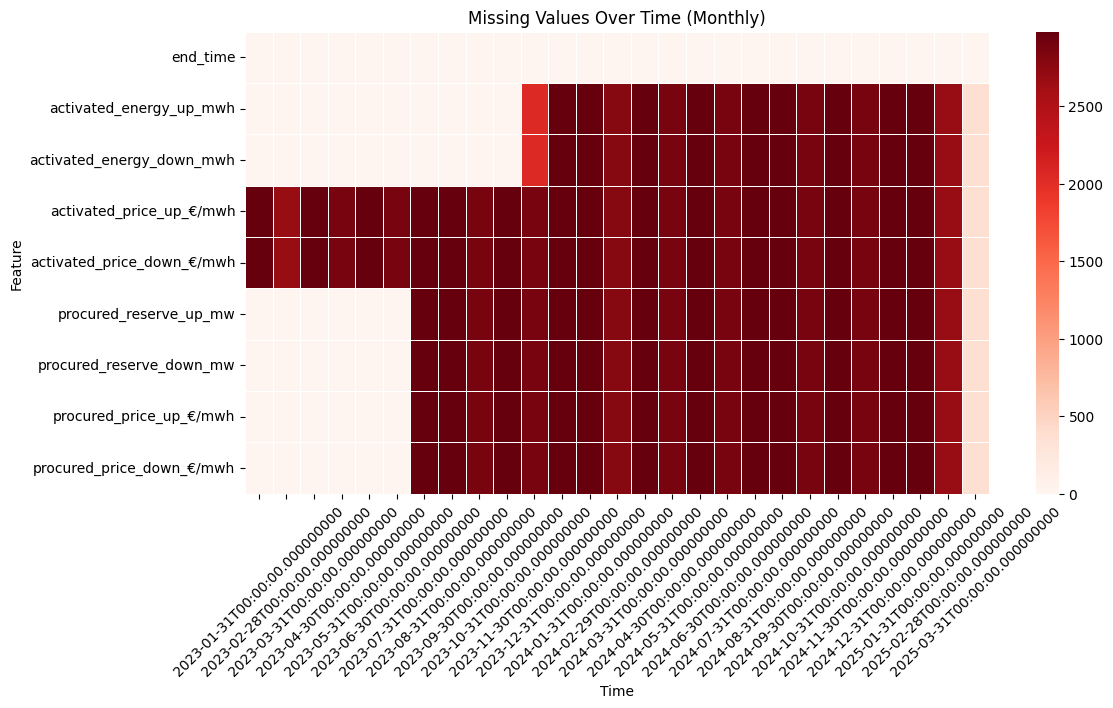

              Count                                                    \
           end_time activated_energy_up_mwh activated_energy_down_mwh   
start_time                                                              
2024-04-30        0                    2880                      2880   
2024-05-31        0                    2976                      2976   
2024-06-30        0                    2880                      2880   
2024-07-31        0                    2976                      2976   
2024-08-31        0                    2976                      2976   
2024-09-30        0                    2880                      2880   
2024-10-31        0                    2980                      2980   
2024-11-30        0                    2880                      2880   
2024-12-31        0                    2976                      2976   
2025-01-31        0                    2976                      2976   
2025-02-28        0                    2688        

In [48]:
df = auto_freq_restore_quarterhourly_df.copy()

df['start_time'] = pd.to_datetime(df['start_time'])

df.set_index('start_time', inplace=True)

missing_counts = df.isna().resample('M').sum()

# Plot missing values over time
plt.figure(figsize=(12, 6))
sns.heatmap(missing_counts.T, cmap="Reds", cbar=True, linewidths=0.5)
plt.title("Missing Values Over Time (Monthly)")
plt.xlabel("Time")
plt.ylabel("Feature")
plt.xticks(rotation=45)
plt.show()

# Print summary statistics of missing values by month
missing_summary = df.isna().resample('M').sum()
missing_summary_percentage = df.isna().resample('M').mean() * 100

missing_summary_df = pd.concat([missing_summary, missing_summary_percentage], axis=1, keys=['Count', 'Percentage'])
print(missing_summary_df.tail(12))  # Show last 12 months for a relevant summary


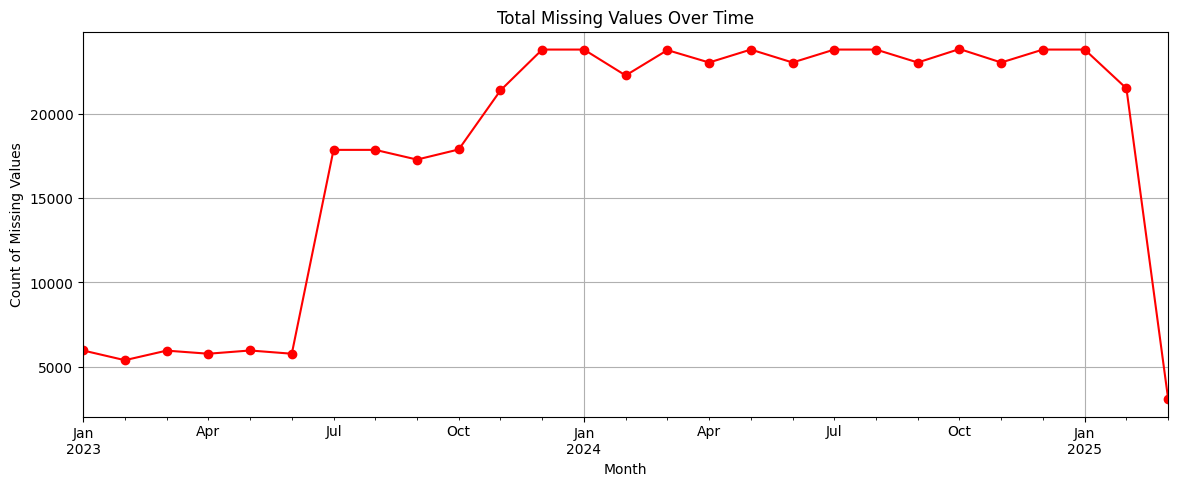

In [49]:
df_missing = auto_freq_restore_quarterhourly_df.copy()
df_missing['start_time'] = pd.to_datetime(df_missing['start_time'])
df_missing.set_index('start_time', inplace=True)

missing_by_month = df_missing.resample('M').apply(lambda x: x.isna().sum())

# Normalize missing values to percentage
missing_percentage = (missing_by_month / len(df_missing)) * 100

# Plot missing value trends
plt.figure(figsize=(14, 5))
missing_by_month.sum(axis=1).plot(marker='o', linestyle='-', color='red')
plt.title("Total Missing Values Over Time")
plt.xlabel("Month")
plt.ylabel("Count of Missing Values")
plt.grid()
plt.show()


Results indicate that **certain columns have 100% missing values from April 2024 onward**:  

1. **Completely Missing Data**  
   - `activated_price_up_€/mwh` and `activated_price_down_€/mwh` are missing **for all timestamps** (100% missing overall).  
   - **Since April 2024**, all `activated_energy_*`, `procured_reserve_*`, and `procured_price_*` columns are **fully missing (100%)**.  

2. **Possible Explanations:**  
   - **Data reporting stopped**: There could be changes in how the data is collected or published from April 2024 onward.  
   - **Dataset issue**: The source may not have provided data beyond a certain date.  
   - **Filtering or extraction error**: If the data was retrieved from an API or file, ensure post-April 2024 values were not unintentionally removed.  


- **Before November 2023**, there were no missing values.
- **From November 2023 onwards**, missing values appear in multiple columns, peaking at ~3.9% per month.
- **March 2025 has fewer missing values (~0.5%)**, suggesting an improvement or partial data availability.

In [50]:
auto_freq_restore_quarterhourly_df.head(2)

,start_time,end_time,activated_energy_up_mwh,activated_energy_down_mwh,activated_price_up_€/mwh,activated_price_down_€/mwh,procured_reserve_up_mw,procured_reserve_down_mw,procured_price_up_€/mwh,procured_price_down_€/mwh
0,2023-01-01 00:00:00,2023-01-01 00:15:00,0.00,15.50,NaN,NaN,1941.0,2029.0,0.52,7.52
1,2023-01-01 00:15:00,2023-01-01 00:30:00,20.75,41.75,NaN,NaN,1941.0,2029.0,0.52,7.52


In [51]:
auto_freq_restore_quarterhourly_df.columns

Index(['start_time', 'end_time', 'activated_energy_up_mwh',
       'activated_energy_down_mwh', 'activated_price_up_€/mwh',
       'activated_price_down_€/mwh', 'procured_reserve_up_mw',
       'procured_reserve_down_mw', 'procured_price_up_€/mwh',
       'procured_price_down_€/mwh'],
      dtype='object')

In [52]:
# Melt the DataFrame to long format
df_auto_freq_restore_copy = auto_freq_restore_quarterhourly_df.melt(
    id_vars=["start_time", "end_time"],
    var_name="category",   # The original column names become categories
    value_name="value"
)

# Reorder columns
df_auto_freq_restore_copy = df_auto_freq_restore_copy[["start_time", "end_time", "category", "value"]]

# Display the transformed DataFrame
df_auto_freq_restore_copy.head()


,start_time,end_time,category,value
0,2023-01-01 00:00:00,2023-01-01 00:15:00,activated_energy_up_mwh,0.00
1,2023-01-01 00:15:00,2023-01-01 00:30:00,activated_energy_up_mwh,20.75
2,2023-01-01 00:30:00,2023-01-01 00:45:00,activated_energy_up_mwh,0.00
3,2023-01-01 00:45:00,2023-01-01 01:00:00,activated_energy_up_mwh,19.00
4,2023-01-01 01:00:00,2023-01-01 01:15:00,activated_energy_up_mwh,155.00


In [53]:
df_auto_freq_restore_copy['category'].unique()

array(['activated_energy_up_mwh', 'activated_energy_down_mwh',
       'activated_price_up_€/mwh', 'activated_price_down_€/mwh',
       'procured_reserve_up_mw', 'procured_reserve_down_mw',
       'procured_price_up_€/mwh', 'procured_price_down_€/mwh'],
      dtype=object)

#### 3.3.4 Deeper Organisation of `balancing_energy_monthly_df`

In [54]:
balancing_energy_monthly_df.columns

Index(['start_date', 'end_date', 'volume_+_mwh', 'volume_-_mwh', 'price_€/mwh',
       'net_income_€'],
      dtype='object')

In [55]:
balancing_energy_monthly_df.head(2)

,start_date,end_date,volume_+_mwh,volume_-_mwh,price_€/mwh,net_income_€
0,2023-01-01 00:00:00,2023-01-01 00:15:00,NaN,NaN,185.56,31476878.85
1,2023-01-01 00:15:00,2023-01-01 00:30:00,NaN,NaN,-78.96,NaN


In [56]:
balancing_energy_monthly_df.rename(columns={
    'start_date': 'start_time',
    'end_date': 'end_time',
    'volume_+_mwh': 'bal_volume_up_mwh',
    'volume_-_mwh': 'bal_volume_down_mwh',
    'price_€/mwh': 'bal_price_€/mwh',
    'net_income_€': 'bal_net_income_eur'
}, inplace=True)


In [57]:
balancing_energy_monthly_df.describe().T

,count,mean,min,25%,50%,75%,max,std
start_time,76224,2024-02-02 00:24:46.020151552,2023-01-01 00:00:00,2023-07-18 12:56:15,2024-02-01 23:52:30,2024-08-18 12:48:45,2025-03-04 23:45:00,NaN
end_time,76224,2024-02-02 00:39:43.753148928,2023-01-01 00:15:00,2023-07-18 13:11:15,2024-02-02 00:07:30,2024-08-18 13:03:45,2025-03-05 00:00:00,NaN
bal_volume_up_mwh,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bal_volume_down_mwh,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bal_price_€/mwh,76152.0,93.117496,-6686.37,26.8575,95.61,148.14,14999.99,265.651335
bal_net_income_eur,23.0,26751885.855652,4313886.98,19251899.335,26469601.15,30610335.575,59644323.63,12569718.050311


- volume_up_mwh and volume_down_mwh all missing

In [58]:
balancing_energy_monthly_df.head(2)

,start_time,end_time,bal_volume_up_mwh,bal_volume_down_mwh,bal_price_€/mwh,bal_net_income_eur
0,2023-01-01 00:00:00,2023-01-01 00:15:00,NaN,NaN,185.56,31476878.85
1,2023-01-01 00:15:00,2023-01-01 00:30:00,NaN,NaN,-78.96,NaN


In [59]:
df_balancing_energy_copy = balancing_energy_monthly_df.melt(
    id_vars=['start_time', 'end_time'],
    var_name='category',
    value_name='value'
)

df_balancing_energy_copy.head()


,start_time,end_time,category,value
0,2023-01-01 00:00:00,2023-01-01 00:15:00,bal_volume_up_mwh,NaN
1,2023-01-01 00:15:00,2023-01-01 00:30:00,bal_volume_up_mwh,NaN
2,2023-01-01 00:30:00,2023-01-01 00:45:00,bal_volume_up_mwh,NaN
3,2023-01-01 00:45:00,2023-01-01 01:00:00,bal_volume_up_mwh,NaN
4,2023-01-01 01:00:00,2023-01-01 01:15:00,bal_volume_up_mwh,NaN


In [60]:
df_balancing_energy_copy.describe()

,start_time,end_time,value
count,304896,304896,7.617500e+04
mean,2024-02-02 00:24:46.020150528,2024-02-02 00:39:43.753148928,8.170456e+03
min,2023-01-01 00:00:00,2023-01-01 00:15:00,-6.686370e+03
25%,2023-07-18 12:56:15,2023-07-18 13:11:15,2.687500e+01
50%,2024-02-01 23:52:30,2024-02-02 00:07:30,9.568000e+01
75%,2024-08-18 12:48:45,2024-08-18 13:03:45,1.481950e+02
max,2025-03-04 23:45:00,2025-03-05 00:00:00,5.964432e+07
std,NaN,NaN,5.115200e+05


In [61]:
df_balancing_energy_copy['category'].unique()

array(['bal_volume_up_mwh', 'bal_volume_down_mwh', 'bal_price_€/mwh',
       'bal_net_income_eur'], dtype=object)

#### 3.3.5 Deeper Organisation of `tso_costs_monthly_df` 

In [62]:
tso_costs_monthly_df.describe()

,start_date,end_date,balancing_services_€,network_security_of_the_tsos_€,countertrading_€
count,27,27,2.300000e+01,2.400000e+01,2.400000e+01
mean,2024-01-31 03:33:20,2024-03-01 13:20:00,7.714463e+07,1.833031e+08,1.113278e+07
min,2023-01-01 00:00:00,2023-02-01 00:00:00,2.540672e+07,4.466027e+07,3.216814e+06
25%,2023-07-16 12:00:00,2023-08-16 12:00:00,6.007629e+07,1.083705e+08,4.810209e+06
50%,2024-02-01 00:00:00,2024-03-01 00:00:00,7.175116e+07,1.787579e+08,9.128195e+06
75%,2024-08-16 12:00:00,2024-09-16 00:00:00,8.415049e+07,2.164099e+08,1.759422e+07
max,2025-03-01 00:00:00,2025-04-01 00:00:00,1.814202e+08,3.982759e+08,2.480819e+07
std,NaN,NaN,3.292822e+07,9.426956e+07,6.920888e+06


In [65]:
tso_costs_monthly_df.isnull().mean() * 100

start_date                         0.000000
end_date                           0.000000
balancing_services_€              14.814815
network_security_of_the_tsos_€    11.111111
countertrading_€                  11.111111
dtype: float64

In [64]:
tso_costs_monthly_df.describe().T

,count,mean,min,25%,50%,75%,max,std
start_date,27,2024-01-31 03:33:20,2023-01-01 00:00:00,2023-07-16 12:00:00,2024-02-01 00:00:00,2024-08-16 12:00:00,2025-03-01 00:00:00,NaN
end_date,27,2024-03-01 13:20:00,2023-02-01 00:00:00,2023-08-16 12:00:00,2024-03-01 00:00:00,2024-09-16 00:00:00,2025-04-01 00:00:00,NaN
balancing_services_€,23.0,77144634.625217,25406723.7,60076294.695,71751158.39,84150486.04,181420199.88,32928218.769491
network_security_of_the_tsos_€,24.0,183303102.739583,44660265.49,108370495.765,178757852.155,216409943.05,398275875.99,94269561.391554
countertrading_€,24.0,11132777.497083,3216814.21,4810209.4475,9128194.625,17594220.6575,24808192.41,6920888.374508


In [69]:
tso_costs_monthly_df

,start_date,end_date,balancing_services_€,network_security_of_the_tsos_€,countertrading_€
0,2023-01-01,2023-02-01,7.157855e+07,3.982759e+08,17519420.07
1,2023-02-01,2023-03-01,4.083567e+07,3.362633e+08,19384916.81
2,2023-03-01,2023-04-01,7.175116e+07,2.998916e+08,16184262.39
3,2023-04-01,2023-05-01,8.258149e+07,2.170505e+08,17818622.42
4,2023-05-01,2023-06-01,6.194491e+07,1.278177e+08,18333011.12
5,2023-06-01,2023-07-01,1.296894e+08,7.572729e+07,5596924.18
6,2023-07-01,2023-08-01,1.814202e+08,2.161964e+08,10468820.84
7,2023-08-01,2023-09-01,7.991684e+07,1.139041e+08,24797471.06
8,2023-09-01,2023-10-01,6.794456e+07,1.359547e+08,12792563.85
9,2023-10-01,2023-11-01,8.189231e+07,2.857958e+08,24808192.41


In [ ]:
df_tso_costs_copy = tso_costs_monthly_df.melt(
    id_vars=['start_date', 'end_date'],
    var_name='category',
    value_name='value'
)

df_tso_costs_copy.head()

,start_date,end_date,category,value
0,2023-01-01,2023-02-01,balancing_services_€,71578546.31
1,2023-02-01,2023-03-01,balancing_services_€,40835671.81
2,2023-03-01,2023-04-01,balancing_services_€,71751158.39
3,2023-04-01,2023-05-01,balancing_services_€,82581492.42
4,2023-05-01,2023-06-01,balancing_services_€,61944912.17


In [ ]:
df_tso_costs_copy['category'].unique()

array(['balancing_services_€', 'network_security_of_the_tsos_€',
       'countertrading_€'], dtype=object)

#### 3.3.6 Deeper Organisation of `cross_border_quarterhourly_df`

In [ ]:
cross_border_quarterhourly_df.columns

Index(['start_date', 'end_date', 'net_export_mwh', 'netherlands_export_mwh',
       'netherlands_import_mwh', 'switzerland_export_mwh',
       'switzerland_import_mwh', 'denmark_export_mwh', 'denmark_import_mwh',
       'czech_republic_export_mwh', 'czech_republic_import_mwh',
       'luxembourg_export_mwh', 'luxembourg_import_mwh', 'sweden_export_mwh',
       'sweden_import_mwh', 'austria_export_mwh', 'austria_import_mwh',
       'france_export_mwh', 'france_import_mwh', 'poland_export_mwh',
       'poland_import_mwh', 'norway_export_mwh', 'norway_import_mwh',
       'belgium_export_mwh', 'belgium_import_mwh'],
      dtype='object')

In [ ]:
cross_border_quarterhourly_df.head(2)

,start_date,end_date,net_export_mwh,netherlands_export_mwh,netherlands_import_mwh,switzerland_export_mwh,switzerland_import_mwh,denmark_export_mwh,denmark_import_mwh,czech_republic_export_mwh,...,austria_export_mwh,austria_import_mwh,france_export_mwh,france_import_mwh,poland_export_mwh,poland_import_mwh,norway_export_mwh,norway_import_mwh,belgium_export_mwh,belgium_import_mwh
0,2023-01-01 00:00:00,2023-01-01 00:15:00,3013.75,226.00,-186.75,545.0,0.0,691.0,0.0,348.25,...,564.75,-25.5,215.25,-1.0,266.25,0.0,306.75,0.0,46.25,0.0
1,2023-01-01 00:15:00,2023-01-01 00:30:00,3011.50,294.25,-259.75,545.5,0.0,653.5,0.0,348.25,...,621.50,-29.5,215.25,-1.0,266.25,0.0,322.00,0.0,42.00,0.0


- Restructuring

In [ ]:
# Melting the dataframe to convert wide format into long format
df_cross_border_quarterhourly_copy = cross_border_quarterhourly_df.melt(
    id_vars=['start_date', 'end_date', 'net_export_mwh'], 
    var_name='country_flow', 
    value_name='energy_mwh'
)

# Splitting 'country_flow' into separate 'country' and 'flow_direction' columns
df_cross_border_quarterhourly_copy[['country', 'flow_direction']] = df_cross_border_quarterhourly_copy['country_flow'].str.rsplit('_', n=1, expand=True)

# Standardizing flow direction naming
df_cross_border_quarterhourly_copy['flow_direction'] = df_cross_border_quarterhourly_copy['flow_direction'].replace({'export': 'exp', 'import': 'imp'})

# Dropping the original 'country_flow' column
df_cross_border_quarterhourly_copy.drop(columns=['country_flow'], inplace=True)

# Reordering columns
df_cross_border_quarterhourly_copy = df_cross_border_quarterhourly_copy[['start_date', 'end_date', 'country', 'flow_direction', 'energy_mwh', 'net_export_mwh']]

# Extract flow direction (last part of the string) and replace the column
df_cross_border_quarterhourly_copy['flow_direction'] = df_cross_border_quarterhourly_copy['country'].str.extract(r'(_export|_import)$')[0]

# Replace '_export' and '_import' with 'exp' and 'imp' respectively
df_cross_border_quarterhourly_copy['flow_direction'] = df_cross_border_quarterhourly_copy['flow_direction'].replace({'_export': 'export', '_import': 'import'})

# Remove the suffix from the country column to retain only the country names
df_cross_border_quarterhourly_copy['country'] = df_cross_border_quarterhourly_copy['country'].str.replace(r'(_export|_import)$', '', regex=True)

# df_cross_border_quarterhourly_copy.loc[df_cross_border_quarterhourly_copy['net_export_mwh'].isna(), 'flow_direction'] = np.nan

# df_cross_border_quarterhourly_copy.loc[df_cross_border_quarterhourly_copy['net_export_mwh'].notna(), 'flow_direction'] = 'export'

df_cross_border_quarterhourly_copy.head()


,start_date,end_date,country,flow_direction,energy_mwh,net_export_mwh
0,2023-01-01 00:00:00,2023-01-01 00:15:00,netherlands,export,226.00,3013.75
1,2023-01-01 00:15:00,2023-01-01 00:30:00,netherlands,export,294.25,3011.50
2,2023-01-01 00:30:00,2023-01-01 00:45:00,netherlands,export,299.50,2984.00
3,2023-01-01 00:45:00,2023-01-01 01:00:00,netherlands,export,295.75,2992.50
4,2023-01-01 01:00:00,2023-01-01 01:15:00,netherlands,export,343.50,3637.00


In [ ]:
df_cross_border_quarterhourly_copy['flow_direction'].unique()

array(['export', 'import'], dtype=object)

In [ ]:
df_cross_border_quarterhourly_copy[['net_export_mwh','flow_direction']]

,net_export_mwh,flow_direction
0,3013.75,export
1,3011.50,export
2,2984.00,export
3,2992.50,export
4,3637.00,export
...,...,...
1676923,NaN,import
1676924,NaN,import
1676925,NaN,import
1676926,NaN,import


In [ ]:
cross_border_quarterhourly_df.columns

Index(['start_date', 'end_date', 'net_export_mwh', 'netherlands_export_mwh',
       'netherlands_import_mwh', 'switzerland_export_mwh',
       'switzerland_import_mwh', 'denmark_export_mwh', 'denmark_import_mwh',
       'czech_republic_export_mwh', 'czech_republic_import_mwh',
       'luxembourg_export_mwh', 'luxembourg_import_mwh', 'sweden_export_mwh',
       'sweden_import_mwh', 'austria_export_mwh', 'austria_import_mwh',
       'france_export_mwh', 'france_import_mwh', 'poland_export_mwh',
       'poland_import_mwh', 'norway_export_mwh', 'norway_import_mwh',
       'belgium_export_mwh', 'belgium_import_mwh'],
      dtype='object')

In [ ]:
df_cross_border_quarterhourly_copy['flow_direction'].unique()

array(['export', 'import'], dtype=object)

In [ ]:
df_cross_border_quarterhourly_copy.describe().T

,count,mean,min,25%,50%,75%,max,std
start_date,1676928,2024-02-02 00:24:46.020153088,2023-01-01 00:00:00,2023-07-18 12:56:15,2024-02-01 23:52:30,2024-08-18 12:48:45,2025-03-04 23:45:00,NaN
end_date,1676928,2024-02-02 00:39:43.753148160,2023-01-01 00:15:00,2023-07-18 13:11:15,2024-02-02 00:07:30,2024-08-18 13:03:45,2025-03-05 00:00:00,NaN
energy_mwh,1676563.0,-20.677781,-1557.5,-109.25,0.0,61.25,1364.25,257.560756
net_export_mwh,1676158.0,-454.716111,-4395.25,-1760.75,-604.25,730.75,4708.5,1625.626278


In [ ]:
missing_values = df_cross_border_quarterhourly_copy.isna().sum()
missing_percentage = (missing_values / len(df_cross_border_quarterhourly_copy)) * 100

missing_df = pd.DataFrame({'Missing Values': missing_values, 'Missing Percentage': missing_percentage})
missing_df


,Missing Values,Missing Percentage
start_date,0,0.000000
end_date,0,0.000000
country,0,0.000000
flow_direction,770,0.045917
energy_mwh,365,0.021766
net_export_mwh,770,0.045917


In [ ]:
missing_rows = df_cross_border_quarterhourly_copy[df_cross_border_quarterhourly_copy.isna().any(axis=1)]
missing_rows


,start_date,end_date,country,flow_direction,energy_mwh,net_export_mwh
50781,2024-06-13 00:15:00,2024-06-13 00:30:00,netherlands,export,385.00,NaN
50782,2024-06-13 00:30:00,2024-06-13 00:45:00,netherlands,export,338.25,NaN
50783,2024-06-13 00:45:00,2024-06-13 01:00:00,netherlands,export,340.25,NaN
50785,2024-06-13 01:15:00,2024-06-13 01:30:00,netherlands,export,435.25,NaN
50786,2024-06-13 01:30:00,2024-06-13 01:45:00,netherlands,export,416.50,NaN
...,...,...,...,...,...,...
1676923,2025-03-04 22:45:00,2025-03-04 23:00:00,belgium,import,NaN,NaN
1676924,2025-03-04 23:00:00,2025-03-04 23:15:00,belgium,import,NaN,NaN
1676925,2025-03-04 23:15:00,2025-03-04 23:30:00,belgium,import,NaN,NaN
1676926,2025-03-04 23:30:00,2025-03-04 23:45:00,belgium,import,NaN,NaN


#### 3.3.7 Deeper Organisation of `day_ahead_price_hourly_df`

Weighted wholesale electricity price (day-ahead price on the exchange) for each hour [€/MWh] determined on the day-ahead auction that took place on the previous day – data is delivered no later than 2 hours after trading closes. [Source: ENTSO-E]
Link to article

Source: https://www.smard.de/blueprint/servlet/page/bnetza-en/wiki-article/5834/5976

In [ ]:
day_ahead_price_hourly_df.columns

Index(['start_date', 'end_date', 'germany/luxembourg_€/mwh',
       '∅_de/lu_neighbours_€/mwh', 'belgium_€/mwh', 'denmark_1_€/mwh',
       'denmark_2_€/mwh', 'france_€/mwh', 'netherlands_€/mwh',
       'norway_2_€/mwh', 'austria_€/mwh', 'poland_€/mwh', 'sweden_4_€/mwh',
       'switzerland_€/mwh', 'czech_republic_€/mwh', 'de/at/lu_€/mwh',
       'northern_italy_€/mwh', 'slovenia_€/mwh', 'hungary_€/mwh'],
      dtype='object')

In [ ]:
day_ahead_price_hourly_df.head(2)

,start_date,end_date,germany/luxembourg_€/mwh,∅_de/lu_neighbours_€/mwh,belgium_€/mwh,denmark_1_€/mwh,denmark_2_€/mwh,france_€/mwh,netherlands_€/mwh,norway_2_€/mwh,austria_€/mwh,poland_€/mwh,sweden_4_€/mwh,switzerland_€/mwh,czech_republic_€/mwh,de/at/lu_€/mwh,northern_italy_€/mwh,slovenia_€/mwh,hungary_€/mwh
0,2023-01-01 00:00:00,2023-01-01 01:00:00,-5.17,13.85,-4.39,2.01,2.01,0.0,-3.61,119.32,12.06,18.09,2.01,0.03,4.84,NaN,195.90,13.31,19.76
1,2023-01-01 01:00:00,2023-01-01 02:00:00,-1.07,9.79,-1.75,1.38,1.38,-0.1,-1.46,108.83,-0.10,5.75,1.38,-7.25,-0.35,NaN,191.09,-0.07,0.19


In [ ]:
day_ahead_price_hourly_df.describe().T

,count,mean,min,25%,50%,75%,max,std
start_date,19056,2024-02-02 00:02:16.020151296,2023-01-01 00:00:00,2023-07-18 12:45:00,2024-02-01 23:30:00,2024-08-18 12:15:00,2025-03-04 23:00:00,NaN
end_date,19056,2024-02-02 01:02:06.952141056,2023-01-01 01:00:00,2023-07-18 13:45:00,2024-02-02 00:30:00,2024-08-18 13:15:00,2025-03-05 00:00:00,NaN
germany/luxembourg_€/mwh,19056.0,89.471532,-500.0,64.7175,90.6,115.7725,936.28,51.631846
∅_de/lu_neighbours_€/mwh,19056.0,84.648631,-152.18,61.12,83.23,107.26,664.26,42.029159
belgium_€/mwh,19056.0,86.579974,-140.0,60.0,88.085,114.69,565.46,47.241271
denmark_1_€/mwh,19056.0,80.655024,-440.1,49.0475,82.355,108.05,936.28,50.894342
denmark_2_€/mwh,19056.0,78.413454,-60.04,40.335,78.795,107.61,936.31,52.510801
france_€/mwh,19056.0,80.1101,-134.94,45.9675,83.15,111.04,473.28,48.041646
netherlands_€/mwh,19056.0,89.194908,-500.0,66.1975,91.375,115.8375,872.96,50.675948
norway_2_€/mwh,19056.0,65.443942,-61.84,41.59,58.94,86.57,898.25,39.114683


- Day ahead price for 'de/at/lu_€/mwh' is NaN althrough with a count of 0, meaning no record. 
- Let's look at the `SMARD` website

Source: SMARD User Guide 2021 (https://www.smard.de/resource/blob/205652/63fcff2c9813096fa2229d769da164ef/smard-user-guide-09-2021-data.pdf): Page 47



<img src="../resources/dayahead_price_userguide.png" width="400" height="500">

- Given this information we can organize the day-ahead price data by bidding zones, countries, and control areas as follows:

In [ ]:
day_ahead_price_hourly_df.head(2)

,start_date,end_date,germany/luxembourg_€/mwh,∅_de/lu_neighbours_€/mwh,belgium_€/mwh,denmark_1_€/mwh,denmark_2_€/mwh,france_€/mwh,netherlands_€/mwh,norway_2_€/mwh,austria_€/mwh,poland_€/mwh,sweden_4_€/mwh,switzerland_€/mwh,czech_republic_€/mwh,de/at/lu_€/mwh,northern_italy_€/mwh,slovenia_€/mwh,hungary_€/mwh
0,2023-01-01 00:00:00,2023-01-01 01:00:00,-5.17,13.85,-4.39,2.01,2.01,0.0,-3.61,119.32,12.06,18.09,2.01,0.03,4.84,NaN,195.90,13.31,19.76
1,2023-01-01 01:00:00,2023-01-01 02:00:00,-1.07,9.79,-1.75,1.38,1.38,-0.1,-1.46,108.83,-0.10,5.75,1.38,-7.25,-0.35,NaN,191.09,-0.07,0.19


In [ ]:
# Reshape the dataframe using melt()
df_day_ahead_price_hourly_copy = day_ahead_price_hourly_df.copy().melt(
    id_vars=["start_date", "end_date"], 
    var_name="region_name", 
    value_name="price (€/MWh)"
)

# Classify each region into region_type:
region_mapping = {
    "germany/luxembourg_€/mwh": "bidding_zone",
    "∅_de/lu_neighbours_€/mwh": "bidding_zone",
    "de/at/lu_€/mwh": "bidding_zone",
    "belgium_€/mwh": "country",
    "france_€/mwh": "country",
    "netherlands_€/mwh": "country",
    "denmark_1_€/mwh": "bidding_zone",
    "denmark_2_€/mwh": "bidding_zone",
    "sweden_4_€/mwh": "bidding_zone",
    "northern_italy_€/mwh": "bidding_zone",
    "austria_€/mwh": "country",
    "luxembourg_€/mwh": "country",
    "czech_republic_€/mwh": "country",
    "poland_€/mwh": "country",
    "switzerland_€/mwh": "country",
    "hungary_€/mwh": "country",
    "slovenia_€/mwh": "country",
    "50hertz_€/mwh": "control_area",
    "amprion_€/mwh": "control_area",
    "tennet_€/mwh": "control_area",
    "transnetbw_€/mwh": "control_area",
    "apg_€/mwh": "control_area",
    "creos_€/mwh": "control_area"
}

df_day_ahead_price_hourly_copy["region_type"] = df_day_ahead_price_hourly_copy["region_name"].map(region_mapping)

df_day_ahead_price_hourly_copy = df_day_ahead_price_hourly_copy[
    ["start_date", "end_date", "region_type", "region_name", "price (€/MWh)"]
]

df_day_ahead_price_hourly_copy["region_name"] = (
    df_day_ahead_price_hourly_copy["region_name"]
    .str.replace("_€/mwh", "", regex=False)
    # .str.replace("_", " ")  # Optional: Replace underscores with spaces
)


df_day_ahead_price_hourly_copy


,start_date,end_date,region_type,region_name,price (€/MWh)
0,2023-01-01 00:00:00,2023-01-01 01:00:00,bidding_zone,germany/luxembourg,-5.17
1,2023-01-01 01:00:00,2023-01-01 02:00:00,bidding_zone,germany/luxembourg,-1.07
2,2023-01-01 02:00:00,2023-01-01 03:00:00,bidding_zone,germany/luxembourg,-1.47
3,2023-01-01 03:00:00,2023-01-01 04:00:00,bidding_zone,germany/luxembourg,-5.08
4,2023-01-01 04:00:00,2023-01-01 05:00:00,bidding_zone,germany/luxembourg,-4.49
...,...,...,...,...,...
323947,2025-03-04 19:00:00,2025-03-04 20:00:00,country,hungary,238.11
323948,2025-03-04 20:00:00,2025-03-04 21:00:00,country,hungary,195.69
323949,2025-03-04 21:00:00,2025-03-04 22:00:00,country,hungary,173.74
323950,2025-03-04 22:00:00,2025-03-04 23:00:00,country,hungary,155.10


In [ ]:
df_day_ahead_price_hourly_copy['region_name'].unique()

array(['germany/luxembourg', '∅_de/lu_neighbours', 'belgium', 'denmark_1',
       'denmark_2', 'france', 'netherlands', 'norway_2', 'austria',
       'poland', 'sweden_4', 'switzerland', 'czech_republic', 'de/at/lu',
       'northern_italy', 'slovenia', 'hungary'], dtype=object)

<img src="../resources/dayahead_price_2.png" width="500" height="300">

<img src="../resources/dayahead_price_1.png" width="700" height="300">


The screenshot from SMARD website (https://www.smard.de/en/marktdaten?marketDataAttributes=%7B%22resolution%22:%22hour%22,%22from%22:1740956400000,%22to%22:1741906799999,%22moduleIds%22:%5B%5D,%22selectedCategory%22:8,%22activeChart%22:false,%22style%22:%22color%22,%22categoriesModuleOrder%22:%7B%7D,%22region%22:%22DE-LU%22%7D) 

confirms that:

- The DE/AT/LU bidding zone existed until 09/30/2018.
- Since 10/01/2018, the DE/LU bidding zone has been used instead.
- Austria now has a separate bidding zone.
- The dataset and SMARD website reflect this split, explaining why no recent DE/AT/LU prices are available.

Conclusion:

- DE/AT/LU prices no longer exist post-2018, which aligns with your dataset showing only missing values ("-").


In [ ]:
df_day_ahead_price_hourly_copy = df_day_ahead_price_hourly_copy[df_day_ahead_price_hourly_copy["region_name"] != "de/at/lu"]


In [ ]:
df_day_ahead_price_hourly_copy.duplicated().sum()

np.int64(0)

In [ ]:
df_day_ahead_price_hourly_copy.isnull().mean() * 100

start_date       0.000000
end_date         0.000000
region_type      6.250000
region_name      0.000000
price (€/MWh)    0.495907
dtype: float64

In [ ]:
df_day_ahead_price_hourly_copy[df_day_ahead_price_hourly_copy["price (€/MWh)"].isnull()]["region_name"].value_counts()


region_name
northern_italy    1512
Name: count, dtype: int64

In [ ]:
northern_italy_df = df_day_ahead_price_hourly_copy[df_day_ahead_price_hourly_copy['region_name'] == 'northern_italy']

northern_italy_df[northern_italy_df['price (€/MWh)'].isnull()][['start_date', 'end_date']].head(10)



,start_date,end_date
284328,2025-01-01 00:00:00,2025-01-01 01:00:00
284329,2025-01-01 01:00:00,2025-01-01 02:00:00
284330,2025-01-01 02:00:00,2025-01-01 03:00:00
284331,2025-01-01 03:00:00,2025-01-01 04:00:00
284332,2025-01-01 04:00:00,2025-01-01 05:00:00
284333,2025-01-01 05:00:00,2025-01-01 06:00:00
284334,2025-01-01 06:00:00,2025-01-01 07:00:00
284335,2025-01-01 07:00:00,2025-01-01 08:00:00
284336,2025-01-01 08:00:00,2025-01-01 09:00:00
284337,2025-01-01 09:00:00,2025-01-01 10:00:00


In [ ]:
df_day_ahead_price_hourly_copy[df_day_ahead_price_hourly_copy['start_date'].isin(northern_italy_df[northern_italy_df['price (€/MWh)'].isnull()]['start_date'])].sort_values(['start_date', 'region_name']).head(20)


,start_date,end_date,region_type,region_name,price (€/MWh)
169992,2025-01-01 00:00:00,2025-01-01 01:00:00,country,austria,109.00
55656,2025-01-01 00:00:00,2025-01-01 01:00:00,country,belgium,10.62
246216,2025-01-01 00:00:00,2025-01-01 01:00:00,country,czech_republic,21.00
74712,2025-01-01 00:00:00,2025-01-01 01:00:00,bidding_zone,denmark_1,2.16
93768,2025-01-01 00:00:00,2025-01-01 01:00:00,bidding_zone,denmark_2,2.54
112824,2025-01-01 00:00:00,2025-01-01 01:00:00,country,france,12.36
17544,2025-01-01 00:00:00,2025-01-01 01:00:00,bidding_zone,germany/luxembourg,2.16
322440,2025-01-01 00:00:00,2025-01-01 01:00:00,country,hungary,147.25
131880,2025-01-01 00:00:00,2025-01-01 01:00:00,country,netherlands,13.62
284328,2025-01-01 00:00:00,2025-01-01 01:00:00,bidding_zone,northern_italy,NaN


In [ ]:
compare_regions = df_day_ahead_price_hourly_copy[
    df_day_ahead_price_hourly_copy['start_date'].between("2025-01-01 00:00:00", "2025-01-01 10:00:00")
].groupby('region_name')['price (€/MWh)'].count()
print(compare_regions)


region_name
austria               11
belgium               11
czech_republic        11
denmark_1             11
denmark_2             11
france                11
germany/luxembourg    11
hungary               11
netherlands           11
northern_italy         0
norway_2              11
poland                11
slovenia              11
sweden_4              11
switzerland           11
∅_de/lu_neighbours    11
Name: price (€/MWh), dtype: int64


In [ ]:
df_day_ahead_price_hourly_copy[df_day_ahead_price_hourly_copy["price (€/MWh)"].isnull()].head()


,start_date,end_date,region_type,region_name,price (€/MWh)
284328,2025-01-01 00:00:00,2025-01-01 01:00:00,bidding_zone,northern_italy,NaN
284329,2025-01-01 01:00:00,2025-01-01 02:00:00,bidding_zone,northern_italy,NaN
284330,2025-01-01 02:00:00,2025-01-01 03:00:00,bidding_zone,northern_italy,NaN
284331,2025-01-01 03:00:00,2025-01-01 04:00:00,bidding_zone,northern_italy,NaN
284332,2025-01-01 04:00:00,2025-01-01 05:00:00,bidding_zone,northern_italy,NaN


In [ ]:
df_raw[['Start date', 'End date','Northern Italy [€/MWh] Original resolutions']].isnull

<bound method DataFrame.isnull of                  Start date              End date  \
0      Jan 1, 2023 12:00 AM   Jan 1, 2023 1:00 AM   
1       Jan 1, 2023 1:00 AM   Jan 1, 2023 2:00 AM   
2       Jan 1, 2023 2:00 AM   Jan 1, 2023 3:00 AM   
3       Jan 1, 2023 3:00 AM   Jan 1, 2023 4:00 AM   
4       Jan 1, 2023 4:00 AM   Jan 1, 2023 5:00 AM   
...                     ...                   ...   
19051   Mar 4, 2025 7:00 PM   Mar 4, 2025 8:00 PM   
19052   Mar 4, 2025 8:00 PM   Mar 4, 2025 9:00 PM   
19053   Mar 4, 2025 9:00 PM  Mar 4, 2025 10:00 PM   
19054  Mar 4, 2025 10:00 PM  Mar 4, 2025 11:00 PM   
19055  Mar 4, 2025 11:00 PM  Mar 5, 2025 12:00 AM   

      Northern Italy [€/MWh] Original resolutions  
0                                          195.90  
1                                          191.09  
2                                          187.95  
3                                          187.82  
4                                          187.74  
...              

In [ ]:
df_raw[['Start date', 'End date','Northern Italy [€/MWh] Original resolutions']].head()

,Start date,End date,Northern Italy [€/MWh] Original resolutions
0,"Jan 1, 2023 12:00 AM","Jan 1, 2023 1:00 AM",195.90
1,"Jan 1, 2023 1:00 AM","Jan 1, 2023 2:00 AM",191.09
2,"Jan 1, 2023 2:00 AM","Jan 1, 2023 3:00 AM",187.95
3,"Jan 1, 2023 3:00 AM","Jan 1, 2023 4:00 AM",187.82
4,"Jan 1, 2023 4:00 AM","Jan 1, 2023 5:00 AM",187.74


In [ ]:
df_raw.columns
# df_original[df_original['region_name'] == 'northern_italy'].head(10)
df_raw[['Start date', 'End date','Northern Italy [€/MWh] Original resolutions']].tail(20)


,Start date,End date,Northern Italy [€/MWh] Original resolutions
19036,"Mar 4, 2025 4:00 AM","Mar 4, 2025 5:00 AM",-
19037,"Mar 4, 2025 5:00 AM","Mar 4, 2025 6:00 AM",-
19038,"Mar 4, 2025 6:00 AM","Mar 4, 2025 7:00 AM",-
19039,"Mar 4, 2025 7:00 AM","Mar 4, 2025 8:00 AM",-
19040,"Mar 4, 2025 8:00 AM","Mar 4, 2025 9:00 AM",-
19041,"Mar 4, 2025 9:00 AM","Mar 4, 2025 10:00 AM",-
19042,"Mar 4, 2025 10:00 AM","Mar 4, 2025 11:00 AM",-
19043,"Mar 4, 2025 11:00 AM","Mar 4, 2025 12:00 PM",-
19044,"Mar 4, 2025 12:00 PM","Mar 4, 2025 1:00 PM",-
19045,"Mar 4, 2025 1:00 PM","Mar 4, 2025 2:00 PM",-


- missing here but confirmed available on SMARD website. We will handle later

#### 3.3.8 Deeper Organisation of `exported_balancing_quarterhourly_df`

In [ ]:
exported_balancing_quarterhourly_df.columns

Index(['start_date', 'end_date', 'austria_mwh'], dtype='object')

In [ ]:
exported_balancing_quarterhourly_df.head(2)

,start_date,end_date,austria_mwh
0,2023-01-01 00:00:00,2023-01-01 00:15:00,57.50
1,2023-01-01 00:15:00,2023-01-01 00:30:00,23.25


In [ ]:
exported_balancing_quarterhourly_df.describe()

,start_date,end_date,austria_mwh
count,76224,76224,32061.000000
mean,2024-02-02 00:24:46.020151552,2024-02-02 00:39:43.753148928,10.343681
min,2023-01-01 00:00:00,2023-01-01 00:15:00,0.000000
25%,2023-07-18 12:56:15,2023-07-18 13:11:15,0.000000
50%,2024-02-01 23:52:30,2024-02-02 00:07:30,3.250000
75%,2024-08-18 12:48:45,2024-08-18 13:03:45,14.250000
max,2025-03-04 23:45:00,2025-03-05 00:00:00,211.750000
std,NaN,NaN,16.499143


In [ ]:
exported_balancing_quarterhourly_df.isnull().mean() * 100

start_date      0.000000
end_date        0.000000
austria_mwh    57.938445
dtype: float64

In [ ]:
exported_balancing_quarterhourly_df[exported_balancing_quarterhourly_df['austria_mwh'].isna()].describe()


,start_date,end_date,austria_mwh
count,44163,44163,0.0
mean,2024-07-17 23:33:21.446912768,2024-07-17 23:48:19.490523904,NaN
min,2023-02-20 16:00:00,2023-02-20 16:15:00,NaN
25%,2024-03-24 23:22:30,2024-03-24 23:37:30,NaN
50%,2024-07-18 00:30:00,2024-07-18 00:45:00,NaN
75%,2024-11-09 23:37:30,2024-11-09 23:52:30,NaN
max,2025-03-04 23:45:00,2025-03-05 00:00:00,NaN
std,NaN,NaN,NaN


In [ ]:
exported_balancing_quarterhourly_df[exported_balancing_quarterhourly_df['austria_mwh'].isna()].describe()

,start_date,end_date,austria_mwh
count,44163,44163,0.0
mean,2024-07-17 23:33:21.446912768,2024-07-17 23:48:19.490523904,NaN
min,2023-02-20 16:00:00,2023-02-20 16:15:00,NaN
25%,2024-03-24 23:22:30,2024-03-24 23:37:30,NaN
50%,2024-07-18 00:30:00,2024-07-18 00:45:00,NaN
75%,2024-11-09 23:37:30,2024-11-09 23:52:30,NaN
max,2025-03-04 23:45:00,2025-03-05 00:00:00,NaN
std,NaN,NaN,NaN


- many missing, many no export balancing in those period
- SMARD website shows zero (0) exports for some days
- we can interpolate during modeling

In [ ]:
df_exported_balancing_copy = exported_balancing_quarterhourly_df.melt(
    id_vars=["start_date", "end_date"], 
    var_name="category", 
    value_name="value"
)

df_exported_balancing_copy.head(2)

,start_date,end_date,category,value
0,2023-01-01 00:00:00,2023-01-01 00:15:00,austria_mwh,57.50
1,2023-01-01 00:15:00,2023-01-01 00:30:00,austria_mwh,23.25


#### 3.3.9 Deeper Organisation of `forecasted_consum_quarterhourly_df`

In [ ]:
forecasted_consum_quarterhourly_df.columns

Index(['start_date', 'end_date', 'total_grid_load_mwh', 'residual_load_mwh'], dtype='object')

In [ ]:
forecasted_consum_quarterhourly_df.head(2)

,start_date,end_date,total_grid_load_mwh,residual_load_mwh
0,2023-01-01 00:00:00,2023-01-01 00:15:00,10652.25,1091.25
1,2023-01-01 00:15:00,2023-01-01 00:30:00,10538.00,703.50


In [ ]:
forecasted_consum_quarterhourly_df.describe()

,start_date,end_date,total_grid_load_mwh,residual_load_mwh
count,76224,76224,76224.000000,76128.000000
mean,2024-02-02 00:24:46.020151552,2024-02-02 00:39:43.753148928,13234.891547,7579.983176
min,2023-01-01 00:00:00,2023-01-01 00:15:00,7597.250000,-3522.500000
25%,2023-07-18 12:56:15,2023-07-18 13:11:15,11369.750000,5282.750000
50%,2024-02-01 23:52:30,2024-02-02 00:07:30,13180.875000,7689.500000
75%,2024-08-18 12:48:45,2024-08-18 13:03:45,15111.562500,10005.250000
max,2025-03-04 23:45:00,2025-03-05 00:00:00,18385.000000,16750.750000
std,NaN,NaN,2281.786161,3436.370935


In [ ]:
forecasted_consum_quarterhourly_df.isnull().mean() * 100

start_date             0.000000
end_date               0.000000
total_grid_load_mwh    0.000000
residual_load_mwh      0.125945
dtype: float64

- a few missing values. 

In [ ]:
# Melt the DataFrame to long format
df_forecasted_consum_copy = forecasted_consum_quarterhourly_df.melt(
    id_vars=["start_date", "end_date"], 
    var_name="category", 
    value_name="value"
)

df_forecasted_consum_copy.head()


,start_date,end_date,category,value
0,2023-01-01 00:00:00,2023-01-01 00:15:00,total_grid_load_mwh,10652.25
1,2023-01-01 00:15:00,2023-01-01 00:30:00,total_grid_load_mwh,10538.00
2,2023-01-01 00:30:00,2023-01-01 00:45:00,total_grid_load_mwh,10380.00
3,2023-01-01 00:45:00,2023-01-01 01:00:00,total_grid_load_mwh,10222.25
4,2023-01-01 01:00:00,2023-01-01 01:15:00,total_grid_load_mwh,10107.75


In [ ]:
df_forecasted_consum_copy['category'].unique()

array(['total_grid_load_mwh', 'residual_load_mwh'], dtype=object)

#### 3.3.10 Deeper Organisation of `forecasted_gen_quarterhourly_df`

In [ ]:
forecasted_gen_quarterhourly_df.columns

Index(['start_date', 'end_date', 'total_mwh', 'photovoltaics_and_wind_mwh',
       'wind_offshore_mwh', 'wind_onshore_mwh', 'photovoltaics_mwh',
       'other_mwh'],
      dtype='object')

In [ ]:
forecasted_gen_quarterhourly_df.head()

,start_date,end_date,total_mwh,photovoltaics_and_wind_mwh,wind_offshore_mwh,wind_onshore_mwh,photovoltaics_mwh,other_mwh
0,2023-01-01 00:00:00,2023-01-01 00:15:00,56012.0,9561.00,867.25,8693.75,0.0,17018.25
1,2023-01-01 00:15:00,2023-01-01 00:30:00,NaN,9834.50,869.25,8965.25,0.0,NaN
2,2023-01-01 00:30:00,2023-01-01 00:45:00,NaN,9814.25,870.25,8944.00,0.0,NaN
3,2023-01-01 00:45:00,2023-01-01 01:00:00,NaN,9784.00,871.50,8912.50,0.0,NaN
4,2023-01-01 01:00:00,2023-01-01 01:15:00,56152.0,9714.00,845.50,8868.50,0.0,17417.25


In [ ]:
forecasted_gen_quarterhourly_df.describe().T

,count,mean,min,25%,50%,75%,max,std
start_date,76224,2024-02-02 00:24:46.020151552,2023-01-01 00:00:00,2023-07-18 12:56:15,2024-02-01 23:52:30,2024-08-18 12:48:45,2025-03-04 23:45:00,NaN
end_date,76224,2024-02-02 00:39:43.753148928,2023-01-01 00:15:00,2023-07-18 13:11:15,2024-02-02 00:07:30,2024-08-18 13:03:45,2025-03-05 00:00:00,NaN
total_mwh,19008.0,50059.958702,20000.0,41343.0,50116.5,58364.0,86901.0,11540.414534
photovoltaics_and_wind_mwh,76128.0,5652.891883,76.25,2794.0,5271.125,8083.0,17628.75,3371.654789
wind_offshore_mwh,76224.0,711.239406,5.75,291.5,700.25,1111.75,1708.0,447.399193
wind_onshore_mwh,76128.0,3300.169491,50.5,1245.9375,2557.875,4808.3125,11660.5,2572.005046
photovoltaics_mwh,76128.0,1640.951033,0.0,0.0,23.75,2540.3125,12073.0,2567.98668
other_mwh,19008.0,27450.402686,1075.25,21070.25,26292.375,32650.875,57355.5,8508.115314


In [ ]:
forecasted_gen_quarterhourly_df.isnull().mean() * 100

start_date                     0.000000
end_date                       0.000000
total_mwh                     75.062972
photovoltaics_and_wind_mwh     0.125945
wind_offshore_mwh              0.000000
wind_onshore_mwh               0.125945
photovoltaics_mwh              0.125945
other_mwh                     75.062972
dtype: float64

In [ ]:
missing_forecasted_gen = forecasted_gen_quarterhourly_df[
    forecasted_gen_quarterhourly_df[['total_mwh', 'other_mwh']].isnull().all(axis=1)
]

print(f"Total missing rows: {len(missing_forecasted_gen)}")

missing_forecasted_gen.head()


Total missing rows: 57216


,start_date,end_date,total_mwh,photovoltaics_and_wind_mwh,wind_offshore_mwh,wind_onshore_mwh,photovoltaics_mwh,other_mwh
1,2023-01-01 00:15:00,2023-01-01 00:30:00,NaN,9834.50,869.25,8965.25,0.0,NaN
2,2023-01-01 00:30:00,2023-01-01 00:45:00,NaN,9814.25,870.25,8944.00,0.0,NaN
3,2023-01-01 00:45:00,2023-01-01 01:00:00,NaN,9784.00,871.50,8912.50,0.0,NaN
5,2023-01-01 01:15:00,2023-01-01 01:30:00,NaN,9687.25,846.75,8840.50,0.0,NaN
6,2023-01-01 01:30:00,2023-01-01 01:45:00,NaN,9672.25,848.75,8823.50,0.0,NaN


In [ ]:
# Check if the sum of photovoltaics_and_wind_mwh and other_mwh matches total_mwh
valid_rows = forecasted_gen_quarterhourly_df.dropna(subset=['total_mwh', 'photovoltaics_and_wind_mwh', 'other_mwh'])

# Check the difference
valid_rows['difference'] = valid_rows['total_mwh'] - (valid_rows['photovoltaics_and_wind_mwh'] + valid_rows['other_mwh'])

# Check if the difference is always zero
consistency_check = (valid_rows['difference'].abs() < 1e-6).all()  # Small tolerance for floating-point precision

# Print result
print(f"Total MWh consistency check: {consistency_check}")


Total MWh consistency check: False


/var/folders/l6/vts3rj213910_pfyglhvktx00000gn/T/ipykernel_16891/2095985967.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
# Compare total_mwh with the sum of photovoltaics_and_wind_mwh and other_mwh
valid_rows.loc[:,'sum_components'] = valid_rows['photovoltaics_and_wind_mwh'] + valid_rows['other_mwh']
valid_rows.loc[:,'difference'] = valid_rows['total_mwh'] - valid_rows['sum_components']

# Check distribution of differences
print(valid_rows['difference'].describe())


count    19008.000000
mean     16958.275121
std      10107.562335
min        244.250000
25%       8399.812500
50%      15837.875000
75%      24219.312500
max      52562.250000
Name: difference, dtype: float64


/var/folders/l6/vts3rj213910_pfyglhvktx00000gn/T/ipykernel_16891/2192583178.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
# Find cases where the absolute difference is high
significant_diff = valid_rows[valid_rows['difference'].abs() > 10]  # Threshold of 10 MWh
significant_diff


,start_date,end_date,total_mwh,photovoltaics_and_wind_mwh,wind_offshore_mwh,wind_onshore_mwh,photovoltaics_mwh,other_mwh,difference,sum_components
0,2023-01-01 00:00:00,2023-01-01 00:15:00,56012.0,9561.00,867.25,8693.75,0.0,17018.25,29432.75,26579.25
4,2023-01-01 01:00:00,2023-01-01 01:15:00,56152.0,9714.00,845.50,8868.50,0.0,17417.25,29020.75,27131.25
8,2023-01-01 02:00:00,2023-01-01 02:15:00,53669.0,9657.00,850.75,8806.25,0.0,15134.75,28877.25,24791.75
12,2023-01-01 03:00:00,2023-01-01 03:15:00,52712.0,9597.25,855.25,8742.00,0.0,14860.75,28254.00,24458.00
16,2023-01-01 04:00:00,2023-01-01 04:15:00,51940.0,9369.50,855.25,8514.25,0.0,14610.75,27959.75,23980.25
...,...,...,...,...,...,...,...,...,...,...
76204,2025-03-04 19:00:00,2025-03-04 19:15:00,53025.0,3442.75,1426.75,2016.00,0.0,38748.25,10834.00,42191.00
76208,2025-03-04 20:00:00,2025-03-04 20:15:00,51923.0,3801.25,1456.50,2344.75,0.0,36116.25,12005.50,39917.50
76212,2025-03-04 21:00:00,2025-03-04 21:15:00,50735.0,4185.50,1513.25,2672.25,0.0,33457.00,13092.50,37642.50
76216,2025-03-04 22:00:00,2025-03-04 22:15:00,50017.0,4463.25,1544.00,2919.25,0.0,31862.00,13691.75,36325.25


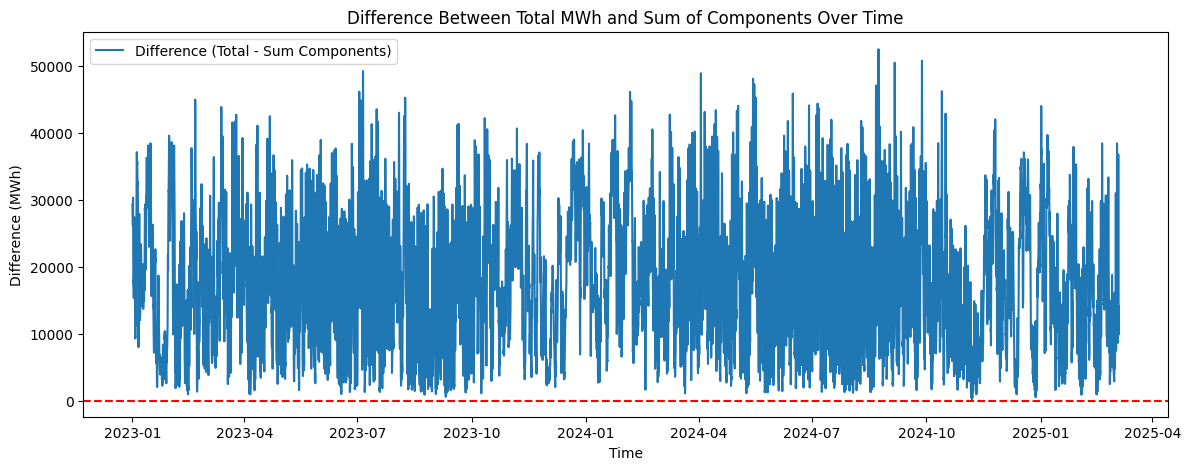

In [ ]:


plt.figure(figsize=(14, 5))
plt.plot(valid_rows['start_date'], valid_rows['difference'], label='Difference (Total - Sum Components)')
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Difference (MWh)')
plt.title('Difference Between Total MWh and Sum of Components Over Time')
plt.legend()
plt.show()


- high missing percentage in total_mwh and other_mwh 

The differences between total_mwh and the sum of photovoltaics_and_wind_mwh + other_mwh are quite large:

- Mean difference: ~16,958 MWh → This suggests a systematic discrepancy.
- Standard deviation: ~10,107 MWh → The differences are highly variable.
- Minimum difference: 244.25 MWh → Even the smallest discrepancy is non-negligible.
- Maximum difference: 52,562.25 MWh → Some cases show extremely high mismatches.

This confirms that total_mwh does not simply represent photovoltaics_and_wind_mwh + other_mwh.

- Restructuring

In [ ]:
# Melt the DataFrame to long format
df_forecasted_gen_copy = forecasted_gen_quarterhourly_df.melt(
    id_vars=["start_date", "end_date"], 
    var_name="category", 
    value_name="value"
)

# Display transformed DataFrame
df_forecasted_gen_copy.head()


,start_date,end_date,category,value
0,2023-01-01 00:00:00,2023-01-01 00:15:00,total_mwh,56012.0
1,2023-01-01 00:15:00,2023-01-01 00:30:00,total_mwh,NaN
2,2023-01-01 00:30:00,2023-01-01 00:45:00,total_mwh,NaN
3,2023-01-01 00:45:00,2023-01-01 01:00:00,total_mwh,NaN
4,2023-01-01 01:00:00,2023-01-01 01:15:00,total_mwh,56152.0


In [ ]:
df_forecasted_gen_copy['category'].unique()

array(['total_mwh', 'photovoltaics_and_wind_mwh', 'wind_offshore_mwh',
       'wind_onshore_mwh', 'photovoltaics_mwh', 'other_mwh'], dtype=object)

#### 3.3.11 Deeper Organisation of `freq_containm_quarterhourly_df`

In [ ]:
freq_containm_quarterhourly_df.columns

Index(['start_date', 'end_date', 'volume_procured_mw',
       'procurement_price_€/mw'],
      dtype='object')

In [ ]:
freq_containm_quarterhourly_df.head(2)

,start_date,end_date,volume_procured_mw,procurement_price_€/mw
0,2023-01-01 00:00:00,2023-01-01 00:15:00,NaN,8.71
1,2023-01-01 00:15:00,2023-01-01 00:30:00,NaN,8.71


In [ ]:
freq_containm_quarterhourly_df.describe()

,start_date,end_date,volume_procured_mw,procurement_price_€/mw
count,76224,76224,0.0,17372.000000
mean,2024-02-02 00:24:46.020151552,2024-02-02 00:39:43.753148928,NaN,3.270608
min,2023-01-01 00:00:00,2023-01-01 00:15:00,NaN,0.860000
25%,2023-07-18 12:56:15,2023-07-18 13:11:15,NaN,1.840000
50%,2024-02-01 23:52:30,2024-02-02 00:07:30,NaN,2.760000
75%,2024-08-18 12:48:45,2024-08-18 13:03:45,NaN,4.130000
max,2025-03-04 23:45:00,2025-03-05 00:00:00,NaN,15.530000
std,NaN,NaN,NaN,1.964891


In [ ]:
freq_containm_quarterhourly_df.isnull().mean() * 100

start_date                  0.000000
end_date                    0.000000
volume_procured_mw        100.000000
procurement_price_€/mw     77.209278
dtype: float64

 
- `volume_procured_mw` is **completely missing (100%)**.  
- `procurement_price_€/mw` is **77.21% missing**.  
- **Timestamps (`start_date`, `end_date`) are fully available**.  

Since `volume_procured_mw` is entirely missing, it may not be useful unless there's an external source to fill it. For `procurement_price_€/mw`, we can check **time periods or patterns** in missingness.  

In [ ]:
freq_containm_quarterhourly_df['start_date'] = pd.to_datetime(freq_containm_quarterhourly_df['start_date'])

freq_containm_quarterhourly_df['year'] = freq_containm_quarterhourly_df['start_date'].dt.year
freq_containm_quarterhourly_df['month'] = freq_containm_quarterhourly_df['start_date'].dt.month

missing_trend = (
    freq_containm_quarterhourly_df
    .groupby(['year', 'month'])['procurement_price_€/mw']
    .apply(lambda x: x.isnull().mean() * 100)
    .reset_index(name='missing_percentage')
)

print(missing_trend)


    year  month  missing_percentage
0   2023      1                 0.0
1   2023      2                 0.0
2   2023      3                 0.0
3   2023      4                 0.0
4   2023      5                 0.0
5   2023      6                 0.0
6   2023      7               100.0
7   2023      8               100.0
8   2023      9               100.0
9   2023     10               100.0
10  2023     11               100.0
11  2023     12               100.0
12  2024      1               100.0
13  2024      2               100.0
14  2024      3               100.0
15  2024      4               100.0
16  2024      5               100.0
17  2024      6               100.0
18  2024      7               100.0
19  2024      8               100.0
20  2024      9               100.0
21  2024     10               100.0
22  2024     11               100.0
23  2024     12               100.0
24  2025      1               100.0
25  2025      2               100.0
26  2025      3             

The data shows that `procurement_price_€/mw` is fully available from **January to June 2023** but is entirely missing from **July 2023 onward** (including all of 2024 and 2025).  

**Could be due to**:
1. **Regulatory or Market Changes** – Did procurement pricing stop being reported after June 2023?  
2. **Data Collection Issues** – Maybe the data source no longer provides procurement price information.  
3. **Structural Change in Frequency Containment Reserve (FCR) Market** – A change in procurement mechanisms might have caused this.  

- Restructuring

In [ ]:
freq_containm_quarterhourly_df.head(2)

,start_date,end_date,volume_procured_mw,procurement_price_€/mw,year,month
0,2023-01-01 00:00:00,2023-01-01 00:15:00,NaN,8.71,2023,1
1,2023-01-01 00:15:00,2023-01-01 00:30:00,NaN,8.71,2023,1


In [ ]:
# Melt the DataFrame to long format
df_freq_containm_copy = freq_containm_quarterhourly_df.melt(
    id_vars=["start_date", "end_date"], 
    var_name="category", 
    value_name="value"
)

df_freq_containm_copy.head()


,start_date,end_date,category,value
0,2023-01-01 00:00:00,2023-01-01 00:15:00,volume_procured_mw,NaN
1,2023-01-01 00:15:00,2023-01-01 00:30:00,volume_procured_mw,NaN
2,2023-01-01 00:30:00,2023-01-01 00:45:00,volume_procured_mw,NaN
3,2023-01-01 00:45:00,2023-01-01 01:00:00,volume_procured_mw,NaN
4,2023-01-01 01:00:00,2023-01-01 01:15:00,volume_procured_mw,NaN


In [ ]:
df_freq_containm_copy['category'].unique()

array(['volume_procured_mw', 'procurement_price_€/mw', 'year', 'month'],
      dtype=object)

#### 3.3.12 Deeper Organisation of `gen_forecast_quarterhourly_df`

In [ ]:
gen_forecast_quarterhourly_df.columns

Index(['start_date', 'end_date', 'photovoltaics_and_wind_mwh',
       'wind_offshore_mwh', 'wind_onshore_mwh', 'photovoltaics_mwh'],
      dtype='object')

In [ ]:
gen_forecast_quarterhourly_df.head(2)

,start_date,end_date,photovoltaics_and_wind_mwh,wind_offshore_mwh,wind_onshore_mwh,photovoltaics_mwh
0,2023-01-01 00:00:00,2023-01-01 00:15:00,8419.50,608.75,7810.75,0.0
1,2023-01-01 00:15:00,2023-01-01 00:30:00,8119.25,590.25,7529.00,0.0


In [ ]:
gen_forecast_quarterhourly_df.describe().T

,count,mean,min,25%,50%,75%,max,std
start_date,76224,2024-02-02 00:24:46.020151552,2023-01-01 00:00:00,2023-07-18 12:56:15,2024-02-01 23:52:30,2024-08-18 12:48:45,2025-03-04 23:45:00,NaN
end_date,76224,2024-02-02 00:39:43.753148928,2023-01-01 00:15:00,2023-07-18 13:11:15,2024-02-02 00:07:30,2024-08-18 13:03:45,2025-03-05 00:00:00,NaN
photovoltaics_and_wind_mwh,76224.0,5662.110083,68.5,2786.25,5278.25,8124.8125,18547.25,3395.65496
wind_offshore_mwh,76224.0,705.336633,1.5,275.0,682.0,1108.0625,1780.75,457.087207
wind_onshore_mwh,76224.0,3307.794733,30.5,1238.4375,2590.5,4828.5,11885.0,2585.677325
photovoltaics_mwh,76224.0,1648.978717,0.0,0.0,23.0,2556.25,12148.5,2584.071216


In [ ]:
gen_forecast_quarterhourly_df.isnull().mean() * 100

start_date                    0.0
end_date                      0.0
photovoltaics_and_wind_mwh    0.0
wind_offshore_mwh             0.0
wind_onshore_mwh              0.0
photovoltaics_mwh             0.0
dtype: float64

In [ ]:
gen_forecast_quarterhourly_df.head(2)

,start_date,end_date,photovoltaics_and_wind_mwh,wind_offshore_mwh,wind_onshore_mwh,photovoltaics_mwh
0,2023-01-01 00:00:00,2023-01-01 00:15:00,8419.50,608.75,7810.75,0.0
1,2023-01-01 00:15:00,2023-01-01 00:30:00,8119.25,590.25,7529.00,0.0


- No missingnesss!!!

- Restructuring

In [ ]:
# Melt the DataFrame to long format
df_gen_forecast_quarterhourly_copy = gen_forecast_quarterhourly_df.melt(
    id_vars=["start_date", "end_date"], 
    var_name="category", 
    value_name="value"
)

# Display transformed DataFrame
df_gen_forecast_quarterhourly_copy.head()


,start_date,end_date,category,value
0,2023-01-01 00:00:00,2023-01-01 00:15:00,photovoltaics_and_wind_mwh,8419.50
1,2023-01-01 00:15:00,2023-01-01 00:30:00,photovoltaics_and_wind_mwh,8119.25
2,2023-01-01 00:30:00,2023-01-01 00:45:00,photovoltaics_and_wind_mwh,7909.50
3,2023-01-01 00:45:00,2023-01-01 01:00:00,photovoltaics_and_wind_mwh,7961.50
4,2023-01-01 01:00:00,2023-01-01 01:15:00,photovoltaics_and_wind_mwh,7748.25


In [ ]:
df_gen_forecast_quarterhourly_copy['category'].unique()

array(['photovoltaics_and_wind_mwh', 'wind_offshore_mwh',
       'wind_onshore_mwh', 'photovoltaics_mwh'], dtype=object)

#### 3.3.13 Deeper Organisation of `imported_balancing_quarterhourly_df`

In [ ]:
imported_balancing_quarterhourly_df.columns

Index(['start_date', 'end_date', 'austria_mwh'], dtype='object')

In [ ]:
imported_balancing_quarterhourly_df.head(2)

,start_date,end_date,austria_mwh
0,2023-01-01 00:00:00,2023-01-01 00:15:00,0.25
1,2023-01-01 00:15:00,2023-01-01 00:30:00,0.00


In [ ]:
imported_balancing_quarterhourly_df.describe()

,start_date,end_date,austria_mwh
count,76224,76224,32061.000000
mean,2024-02-02 00:24:46.020151552,2024-02-02 00:39:43.753148928,10.733118
min,2023-01-01 00:00:00,2023-01-01 00:15:00,0.000000
25%,2023-07-18 12:56:15,2023-07-18 13:11:15,0.250000
50%,2024-02-01 23:52:30,2024-02-02 00:07:30,4.000000
75%,2024-08-18 12:48:45,2024-08-18 13:03:45,15.750000
max,2025-03-04 23:45:00,2025-03-05 00:00:00,178.000000
std,NaN,NaN,15.461879


In [ ]:
imported_balancing_quarterhourly_df.isnull().mean() * 100

start_date      0.000000
end_date        0.000000
austria_mwh    57.938445
dtype: float64

- imported balancing has the same error pattern like the exported balancing
The **imported balancing data** shows the same missing pattern as the **exported balancing data**—about **57.94% missing values** in `austria_mwh`. This suggests that there were likely **no balancing imports** during those periods rather than data reporting issues.  

In [ ]:
# Melt the DataFrame to long format
df_imported_balancing_copy = imported_balancing_quarterhourly_df.melt(
    id_vars=["start_date", "end_date"], 
    var_name="category", 
    value_name="value"
)

df_imported_balancing_copy.head(2)


,start_date,end_date,category,value
0,2023-01-01 00:00:00,2023-01-01 00:15:00,austria_mwh,0.25
1,2023-01-01 00:15:00,2023-01-01 00:30:00,austria_mwh,0.00


In [ ]:
df_imported_balancing_copy['category'].unique()

array(['austria_mwh'], dtype=object)

#### 3.3.14 Deeper Organisation of `installed_gen_yearly_df`

In [ ]:
installed_gen_yearly_df.columns

Index(['start_date', 'end_date', 'biomass_mw', 'hydropower_mw',
       'wind_offshore_mw', 'wind_onshore_mw', 'photovoltaics_mw',
       'other_renewable_mw', 'nuclear_mw', 'lignite_mw', 'hard_coal_mw',
       'fossil_gas_mw', 'hydro_pumped_storage_mw', 'other_conventional_mw'],
      dtype='object')

In [ ]:
installed_gen_yearly_df.head(2)

,start_date,end_date,biomass_mw,hydropower_mw,wind_offshore_mw,wind_onshore_mw,photovoltaics_mw,other_renewable_mw,nuclear_mw,lignite_mw,hard_coal_mw,fossil_gas_mw,hydro_pumped_storage_mw,other_conventional_mw
0,2023-01-01,2024-01-01,8467.0,5049.0,8129.0,57590.0,63066.0,440.0,4056.0,17692.0,18559.0,31808.0,9379.0,8958.0
1,2024-01-01,2025-01-01,8577.0,5112.0,8456.0,59841.0,76601.0,410.0,NaN,18363.0,18411.0,36255.0,9449.0,8813.0


- first restructure

In [ ]:
df_installed_gen_yearly_copy = installed_gen_yearly_df.melt(
    id_vars=["start_date", "end_date"], 
    var_name="category", 
    value_name="value"
)
# df_installed_gen_yearly_copy["energy_source"] = df_installed_gen_yearly_copy["energy_source"].str.replace("_mw", "", regex=False)
df_installed_gen_yearly_copy.head(2)


,start_date,end_date,category,value
0,2023-01-01,2024-01-01,biomass_mw,8467.0
1,2024-01-01,2025-01-01,biomass_mw,8577.0


In [ ]:
df_installed_gen_yearly_copy.describe()

,start_date,end_date,value
count,36,36,34.000000
mean,2024-01-01 08:00:00,2024-12-31 16:00:00,22015.058824
min,2023-01-01 00:00:00,2024-01-01 00:00:00,410.000000
25%,2023-01-01 00:00:00,2024-01-01 00:00:00,8458.750000
50%,2024-01-01 00:00:00,2025-01-01 00:00:00,9416.500000
75%,2025-01-01 00:00:00,2026-01-01 00:00:00,28495.750000
max,2025-01-01 00:00:00,2026-01-01 00:00:00,86408.000000
std,NaN,NaN,23609.316072


In [ ]:
installed_gen_yearly_df.describe().T

,count,mean,min,25%,50%,75%,max,std
start_date,3,2024-01-01 08:00:00,2023-01-01 00:00:00,2023-07-02 12:00:00,2024-01-01 00:00:00,2024-07-02 00:00:00,2025-01-01 00:00:00,NaN
end_date,3,2024-12-31 16:00:00,2024-01-01 00:00:00,2024-07-02 00:00:00,2025-01-01 00:00:00,2025-07-02 12:00:00,2026-01-01 00:00:00,NaN
biomass_mw,3.0,8603.333333,8467.0,8522.0,8577.0,8671.5,8766.0,151.229406
hydropower_mw,3.0,5170.333333,5049.0,5080.5,5112.0,5231.0,5350.0,158.752428
wind_offshore_mw,3.0,8600.0,8129.0,8292.5,8456.0,8835.5,9215.0,557.136429
wind_onshore_mw,3.0,60207.666667,57590.0,58715.5,59841.0,61516.5,63192.0,2818.942059
photovoltaics_mw,3.0,75358.333333,63066.0,69833.5,76601.0,81504.5,86408.0,11720.512204
other_renewable_mw,3.0,432.0,410.0,425.0,440.0,443.0,446.0,19.287302
nuclear_mw,1.0,4056.0,4056.0,4056.0,4056.0,4056.0,4056.0,NaN
lignite_mw,3.0,17077.0,15176.0,16434.0,17692.0,18027.5,18363.0,1680.152076


#### 3.3.15 Deeper Organisation of `manual_freq_quarterhourly_df`

In [ ]:
manual_freq_quarterhourly_df.columns

Index(['start_date', 'end_date', 'volume_activated_+_mwh',
       'volume_activated_-_mwh', 'activation_price_+_€/mwh',
       'activation_price_-_€/mwh', 'volume_procured_+_mw',
       'volume_procured_-_mw', 'procurement_price_+_€/mw',
       'procurement_price_-_€/mw'],
      dtype='object')

In [ ]:
manual_freq_quarterhourly_df.head(2)

,start_date,end_date,volume_activated_+_mwh,volume_activated_-_mwh,activation_price_+_€/mwh,activation_price_-_€/mwh,volume_procured_+_mw,volume_procured_-_mw,procurement_price_+_€/mw,procurement_price_-_€/mw
0,2023-01-01 00:00:00,2023-01-01 00:15:00,NaN,NaN,NaN,NaN,977.0,358.0,0.06,1.66
1,2023-01-01 00:15:00,2023-01-01 00:30:00,NaN,NaN,NaN,NaN,977.0,355.0,0.06,1.66


In [ ]:
manual_freq_quarterhourly_df.describe().T

,count,mean,min,25%,50%,75%,max,std
start_date,76224,2024-02-02 00:24:46.020151552,2023-01-01 00:00:00,2023-07-18 12:56:15,2024-02-01 23:52:30,2024-08-18 12:48:45,2025-03-04 23:45:00,NaN
end_date,76224,2024-02-02 00:39:43.753148928,2023-01-01 00:15:00,2023-07-18 13:11:15,2024-02-02 00:07:30,2024-08-18 13:03:45,2025-03-05 00:00:00,NaN
volume_activated_+_mwh,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
volume_activated_-_mwh,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
activation_price_+_€/mwh,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
activation_price_-_€/mwh,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
volume_procured_+_mw,17372.0,800.188752,565.0,757.0,795.0,836.0,1176.0,69.889387
volume_procured_-_mw,17372.0,423.56758,311.0,388.0,412.0,451.0,740.0,53.877939
procurement_price_+_€/mw,17372.0,0.48764,0.02,0.1,0.27,0.61,5.87,0.62232
procurement_price_-_€/mw,17372.0,1.30341,0.02,0.15,0.36,1.05,24.57,2.672839


- volume_activated_+_mwh, volume_activated_-_mwh, activation_price_+_€/mwh, and activation_price_-_€/mwh are all missing

In [ ]:
# Define a renaming dictionary for consistency
rename_map = {
    "volume_activated_+_mwh": "volume_activated_up_mwh",
    "volume_activated_-_mwh": "volume_activated_down_mwh",
    "activation_price_+_€/mwh": "activation_price_up_€/mwh",
    "activation_price_-_€/mwh": "activation_price_down_€/mwh",
    "volume_procured_+_mw": "volume_procured_up_mw",
    "volume_procured_-_mw": "volume_procured_down_mw",
    "procurement_price_+_€/mw": "procurement_price_up_€/mwh",
    "procurement_price_-_€/mw": "procurement_price_down_€/mwh"
}

manual_freq_quarterhourly_df = manual_freq_quarterhourly_df.rename(columns=rename_map)

df_manual_freq_copy = manual_freq_quarterhourly_df.melt(
    id_vars=["start_date", "end_date"], 
    var_name="category", 
    value_name="value"
)

df_manual_freq_copy.head()


,start_date,end_date,category,value
0,2023-01-01 00:00:00,2023-01-01 00:15:00,volume_activated_up_mwh,NaN
1,2023-01-01 00:15:00,2023-01-01 00:30:00,volume_activated_up_mwh,NaN
2,2023-01-01 00:30:00,2023-01-01 00:45:00,volume_activated_up_mwh,NaN
3,2023-01-01 00:45:00,2023-01-01 01:00:00,volume_activated_up_mwh,NaN
4,2023-01-01 01:00:00,2023-01-01 01:15:00,volume_activated_up_mwh,NaN


In [ ]:
df_manual_freq_copy['category'].unique()

array(['volume_activated_up_mwh', 'volume_activated_down_mwh',
       'activation_price_up_€/mwh', 'activation_price_down_€/mwh',
       'volume_procured_up_mw', 'volume_procured_down_mw',
       'procurement_price_up_€/mwh', 'procurement_price_down_€/mwh'],
      dtype=object)

#### 3.3.16 Deeper Organisation of `scheduled_exchanges_quarterhourly_df`

In [ ]:
scheduled_exchanges_quarterhourly_df.columns

Index(['start_date', 'end_date', 'net_export_mwh', 'netherlands_export_mwh',
       'netherlands_import_mwh', 'switzerland_export_mwh',
       'switzerland_import_mwh', 'denmark_export_mwh', 'denmark_import_mwh',
       'czech_republic_export_mwh', 'czech_republic_import_mwh',
       'luxembourg_export_mwh', 'luxembourg_import_mwh', 'sweden_export_mwh',
       'sweden_import_mwh', 'austria_export_mwh', 'austria_import_mwh',
       'france_export_mwh', 'france_import_mwh', 'poland_export_mwh',
       'poland_import_mwh', 'norway_export_mwh', 'norway_import_mwh',
       'belgium_export_mwh', 'belgium_import_mwh'],
      dtype='object')

In [ ]:
scheduled_exchanges_quarterhourly_df[['start_date','end_date','net_export_mwh','poland_import_mwh']].head(2)

,start_date,end_date,net_export_mwh,poland_import_mwh
0,2023-01-01 00:00:00,2023-01-01 00:15:00,3161.29,-1.43
1,2023-01-01 00:15:00,2023-01-01 00:30:00,3135.99,-1.43


In [ ]:
scheduled_exchanges_quarterhourly_df.describe().T

,count,mean,min,25%,50%,75%,max,std
start_date,76224,2024-02-02 00:24:46.020151552,2023-01-01 00:00:00,2023-07-18 12:56:15,2024-02-01 23:52:30,2024-08-18 12:48:45,2025-03-04 23:45:00,NaN
end_date,76224,2024-02-02 00:39:43.753148928,2023-01-01 00:15:00,2023-07-18 13:11:15,2024-02-02 00:07:30,2024-08-18 13:03:45,2025-03-05 00:00:00,NaN
net_export_mwh,76224.0,-552.167231,-4282.04,-1846.9075,-746.33,585.8,4806.72,1644.979385
netherlands_export_mwh,76224.0,169.902065,0.0,34.25,114.39,258.13,1157.7,173.344819
netherlands_import_mwh,76224.0,-248.784213,-1412.68,-396.06,-153.345,-33.235,0.0,264.824828
switzerland_export_mwh,76224.0,126.135345,0.0,7.75,121.78,200.0,574.28,122.085898
switzerland_import_mwh,76224.0,-223.68453,-1030.29,-415.22,-10.0,0.0,0.0,313.364625
denmark_export_mwh,76224.0,153.521349,0.0,9.4225,71.88,196.6075,1097.1,209.897275
denmark_import_mwh,76224.0,-493.427651,-1045.45,-698.0,-557.275,-294.75,0.0,254.115376
czech_republic_export_mwh,76224.0,143.83619,0.0,13.88,102.03,252.13,644.63,139.397433


- Restructuring

In [ ]:
# # Melt the dataframe into long format
# df_scheduled_exchanges_copy = scheduled_exchanges_quarterhourly_df.melt(
#     id_vars=['start_date', 'end_date', 'net_export_mwh'], 
#     var_name='category', 
#     value_name='value'
# )

# # Extract country and flow direction
# df_scheduled_exchanges_copy[['country', 'flow_direction']] = df_scheduled_exchanges_copy['category'].str.rsplit('_', n=1, expand=True)

# # Remove suffixes from country names
# df_scheduled_exchanges_copy['country'] = df_scheduled_exchanges_copy['country'].str.replace(r'(_export|_import)$', '', regex=True)

# # Drop the original 'flow_direction' column
# df_scheduled_exchanges_copy.drop(columns=['flow_direction'], inplace=True)

# # Extract flow direction (export/import) from 'exchange_direction'
# df_scheduled_exchanges_copy['flow_direction'] = df_scheduled_exchanges_copy['exchange_direction'].str.extract(r'_(export|import)_mwh$')[0]

# # Display the transformed DataFrame
# df_scheduled_exchanges_copy.head()


,start_date,end_date,net_export_mwh,category,value,country
0,2023-01-01 00:00:00,2023-01-01 00:15:00,3161.29,netherlands_export_mwh,378.80,netherlands
1,2023-01-01 00:15:00,2023-01-01 00:30:00,3135.99,netherlands_export_mwh,378.80,netherlands
2,2023-01-01 00:30:00,2023-01-01 00:45:00,3131.54,netherlands_export_mwh,378.80,netherlands
3,2023-01-01 00:45:00,2023-01-01 01:00:00,3128.84,netherlands_export_mwh,378.80,netherlands
4,2023-01-01 01:00:00,2023-01-01 01:15:00,3852.52,netherlands_export_mwh,501.15,netherlands


In [ ]:
# Melt the dataframe into long format
df_scheduled_exchanges_copy = scheduled_exchanges_quarterhourly_df.melt(
    id_vars=['start_date', 'end_date', 'net_export_mwh'], 
    var_name='exchange_direction', 
    value_name='energy_mwh'
)

# Extract flow direction (export/import) from 'exchange_direction'
df_scheduled_exchanges_copy['flow_direction'] = df_scheduled_exchanges_copy['exchange_direction'].str.extract(r'_(export|import)_mwh$')[0]

# Remove flow direction and '_mwh' from 'exchange_direction' to get the country name
df_scheduled_exchanges_copy['country'] = df_scheduled_exchanges_copy['exchange_direction'].str.replace(r'_(export|import)_mwh$', '', regex=True)

# Drop the original 'exchange_direction' column
df_scheduled_exchanges_copy.drop(columns=['exchange_direction'], inplace=True)

# Display the transformed DataFrame
df_scheduled_exchanges_copy.head()


,start_date,end_date,net_export_mwh,energy_mwh,flow_direction,country
0,2023-01-01 00:00:00,2023-01-01 00:15:00,3161.29,378.80,export,netherlands
1,2023-01-01 00:15:00,2023-01-01 00:30:00,3135.99,378.80,export,netherlands
2,2023-01-01 00:30:00,2023-01-01 00:45:00,3131.54,378.80,export,netherlands
3,2023-01-01 00:45:00,2023-01-01 01:00:00,3128.84,378.80,export,netherlands
4,2023-01-01 01:00:00,2023-01-01 01:15:00,3852.52,501.15,export,netherlands


In [ ]:
df_scheduled_exchanges_copy['country'].unique()

array(['netherlands', 'switzerland', 'denmark', 'czech_republic',
       'luxembourg', 'sweden', 'austria', 'france', 'poland', 'norway',
       'belgium'], dtype=object)

In [ ]:
df_scheduled_exchanges_copy['flow_direction'].unique()

array(['export', 'import'], dtype=object)

In [ ]:
df_scheduled_exchanges_copy['flow_direction'].unique()

array(['export', 'import'], dtype=object)

In [ ]:
df_scheduled_exchanges_copy[['flow_direction','net_export_mwh']].nunique()

flow_direction        2
net_export_mwh    60505
dtype: int64

In [ ]:
df_scheduled_exchanges_copy[['start_date','end_date','flow_direction','net_export_mwh', 'country']]

,start_date,end_date,flow_direction,net_export_mwh,country
0,2023-01-01 00:00:00,2023-01-01 00:15:00,export,3161.29,netherlands
1,2023-01-01 00:15:00,2023-01-01 00:30:00,export,3135.99,netherlands
2,2023-01-01 00:30:00,2023-01-01 00:45:00,export,3131.54,netherlands
3,2023-01-01 00:45:00,2023-01-01 01:00:00,export,3128.84,netherlands
4,2023-01-01 01:00:00,2023-01-01 01:15:00,export,3852.52,netherlands
...,...,...,...,...,...
1676923,2025-03-04 22:45:00,2025-03-04 23:00:00,import,2.61,belgium
1676924,2025-03-04 23:00:00,2025-03-04 23:15:00,import,510.59,belgium
1676925,2025-03-04 23:15:00,2025-03-04 23:30:00,import,525.06,belgium
1676926,2025-03-04 23:30:00,2025-03-04 23:45:00,import,589.49,belgium


In [ ]:
df_scheduled_exchanges_copy['country'].unique()

array(['netherlands', 'switzerland', 'denmark', 'czech_republic',
       'luxembourg', 'sweden', 'austria', 'france', 'poland', 'norway',
       'belgium'], dtype=object)

- comparing old and new structure

In [ ]:
# Total import for Poland (using negative values in import column)
total_import_poland = scheduled_exchanges_quarterhourly_df['poland_import_mwh'].sum()
total_import_poland

np.float64(-6013393.720000001)

In [ ]:
# Total import for Poland
total_import_poland = df_scheduled_exchanges_copy.loc[
    (df_scheduled_exchanges_copy['country'] == 'poland') & 
    (df_scheduled_exchanges_copy['flow_direction'] == 'import'),
    'energy_mwh'
].sum()
total_import_poland

np.float64(-6013393.720000001)

In [ ]:
# Net exchange for Poland (Exports - Imports)
net_poland = scheduled_exchanges_quarterhourly_df[['poland_export_mwh', 'poland_import_mwh']].sum(axis=1)
net_poland.unique()

array([   5.  ,  183.52,  195.7 , ...,  -87.42, -139.07, -126.25])

In [ ]:
# Net exchange for Poland
net_poland = df_scheduled_exchanges_copy.loc[df_scheduled_exchanges_copy['country'] == 'poland'].groupby('flow_direction')['energy_mwh'].sum()
net_poland = net_poland.get('export', 0) - net_poland.get('import', 0)
net_poland

np.float64(16404819.2)

<Axes: xlabel='start_date'>

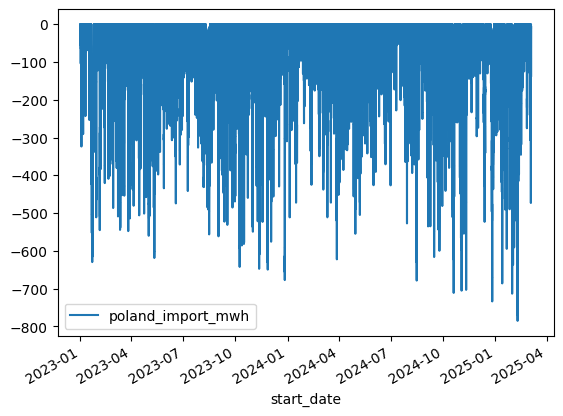

In [ ]:
# Trend of Poland's import over time
scheduled_exchanges_quarterhourly_df[['start_date', 'poland_import_mwh']].plot(x='start_date', y='poland_import_mwh')


## Save Processed Dataframe

In [ ]:
import pickle

# Define the save path
save_path = "../datasets/processed/cleaned_dfs.pkl"

with open(save_path, "wb") as f:
    pickle.dump(cleaned_dfs, f)

print(f"Powercast datasets dictionary saved as: {save_path}")


Powercast datasets dictionary saved as: ../datasets/processed/cleaned_dfs.pkl


In [ ]:
df_tso_costs_copy['category'].unique()

array(['balancing_services_€', 'network_security_of_the_tsos_€',
       'countertrading_€'], dtype=object)

In [ ]:
# Dictionary mapping processed DataFrames to their filenames

deeper_processed_dfs = {
    "df_actual_consum_quarterhourly": df_actual_consum_quarterhourly_copy,
    "df_actual_gen_quarterhourly": df_actual_gen_quarterhourly_copy,
    "df_auto_freq_restore_quarterhourly": df_auto_freq_restore_copy,
    "df_balancing_energy_monthly": df_balancing_energy_copy,
    "df_tso_costs_monthly": df_tso_costs_copy, 
    "df_cross_border_quarterhourly": df_cross_border_quarterhourly_copy,
    "df_day_ahead_price_hourly": df_day_ahead_price_hourly_copy,
    "df_exported_balancing_quarterhourly": df_exported_balancing_copy,
    "df_forecasted_consum_quarterhourly": df_forecasted_consum_copy, #***
    "df_forecasted_gen_quarterhourly": df_forecasted_gen_copy,
    "df_freq_containm_quarterhourly": df_freq_containm_copy,
    "df_gen_forecast_quarterhourly": df_gen_forecast_quarterhourly_copy, #***
    "df_imported_balancing_quarterhourly": df_imported_balancing_copy,
    "df_installed_gen_yearly": df_installed_gen_yearly_copy,
    "df_manual_freq_quarterhourly": df_manual_freq_copy,
    "df_scheduled_exchanges_quarterhourly": df_scheduled_exchanges_copy,
}

# Save each processed DataFrame as a Parquet file
# for filename, df in deeper_processed_dfs.items():
#     df.to_parquet(f"{filename}.parquet", index=False)
    
deeper_save_path = "../datasets/processed/processed_dfs.pkl"

with open(deeper_save_path, "wb") as f:
    pickle.dump(deeper_processed_dfs, f)

print(f"Processed powercast datasets dictionary saved as: {deeper_save_path}!")    

# print("Processed DataFrames saved successfully as Parquet files! ✅")


Processed powercast datasets dictionary saved as: ../datasets/processed/processed_dfs.pkl!
